# *Credit Card Fraud Detection - Task 1*

![logo](images/logo.jpg)

In [1]:
import geodatasets
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sb
import warnings

from geopandas import GeoDataFrame
from shapely.geometry import Point
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kurtosis, norm, normaltest, shapiro, skew

%matplotlib inline

warnings.filterwarnings('ignore')

## Compreensão do Tema

### Compreensão do Tema

Uma fraude de cartão de crédito ocorre quando um indivíduo não autorizado acede à informação do cartão de crédito de outra pessoa para fazer compras em seu nome, indevidamente.

Estas fraudes são um problema cada vez mais comum e recorrente na atualidade, pelo que todas as entidades envolvidas investem significativamente para descobrir padrões e indicadores que podem indiciar situações ou tentativas de fraude.

### Determinação dos Objetivos do Tema

De maneira a ir ao encontro das necessidades dos bancos, reguladores e fornecedores de cartões de crédito, é essencial conseguir prever corretamente se uma transação financeira é, com alta probabilidade, fraudulenta.

Como tal, torna-se extremamente útil desenvolver um modelo que identifique eficazmente transações suspeitas de fraude, de maneira a aumentar a segurança financeira e a reduzir as atividades fraudulentas.

### Avaliação da Situação

Os dados disponíveis para análise foram fornecidos por uma empresa de cartões de crédito, correspondendo a informação de 2023, com registos sobre clientes e comerciantes.

O conjunto de dados inclui informação detalhada sobre cidades, clientes, comerciantes e transações, estando cada transação detalhada como legítima ou fraudulenta, permitindo uma abordagem de aprendizagem supervisionada para identificar padrões indicadores de fraude.

### Determinação dos Objetivos de Mineração de Dados

O problema consiste em prever se uma transação é, ou não, fraudulenta, tendo como base um conjunto de dados associados à transação, ou seja, classificar cada transação como pertencente a um de dois grupos, mutuamente exclusivos: fraudulenta ou legítima (não fraudulenta).

Para resolver o problema, deve ser desenvolvido um modelo de aprendizagem computacional supervisionada com capacidade para efetuar uma classificação binária que distinga os dois casos possíveis para cada transação.

## Compreensão dos Dados

### Recolha dos Dados Iniciais

O conjunto de dados fornecido é constituído por quatro ficheiros, dividindo a informação da forma abaixo exposta.

1. **cities.csv:** informação sobre várias cidades
2. **customers.csv:** informação demográfica de cada cliente
3. **merchants.csv:** detalhes de cada comerciante
4. **transactions.csv:** registos de transações individuais

In [2]:
cities = pd.read_csv('data/cities.csv')
customers = pd.read_csv('data/customers.csv')
merchants = pd.read_csv('data/merchants.csv')
transactions = pd.read_csv('data/transactions.csv')

O ficheiro **cities.csv**, que contém informação sobre várias cidades, é constituído por 5 linhas e 5 colunas.

In [3]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   city      5 non-null      object 
 1   lat       5 non-null      float64
 2   long      5 non-null      float64
 3   city_pop  5 non-null      int64  
 4   state     5 non-null      object 
dtypes: float64(2), int64(1), object(2)
memory usage: 332.0+ bytes


Cada linha representa uma cidade e as colunas são as seguintes:

0. **city:** nome da cidade
1. **lat:** latitude da cidade
2. **lon:** longitude da cidade
3. **city_pop:** população da cidade
4. **state:** estado a que pertence a cidade

In [4]:
cities.head()

,city,lat,long,city_pop,state
0,Los Angeles,34.0522,-118.2437,3979576,CA
1,Houston,29.7604,-95.3698,2328000,TX
2,Phoenix,33.4484,-112.0740,1680992,AZ
3,Chicago,41.8781,-87.6298,2716000,IL
4,New York,40.7128,-74.0060,8419600,NY


O ficheiro **customers.csv**, que contém a informação demográfica de cada cliente, é constituído por 1100 linhas e 9 colunas.

In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cc_num  1100 non-null   int64  
 1   first   1100 non-null   object 
 2   last    1100 non-null   object 
 3   gender  1100 non-null   object 
 4   street  1100 non-null   object 
 5   city    1100 non-null   object 
 6   zip     1080 non-null   float64
 7   job     1080 non-null   object 
 8   dob     1100 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 77.5+ KB


Cada linha representa um cliente e as colunas são as seguintes:

0. **cc_num:** número do cartão de crédito do cliente
1. **first:** primeiro nome do cliente
2. **last:** último nome do cliente
3. **gender:** género do cliente
4. **street:** rua da morada do cliente
5. **city:** cidade da morada do cliente
6. **zip:** código-postal da morada do cliente
7. **job:** emprego do cliente
8. **dob:** data de nascimento do cliente

In [6]:
customers.head()

,cc_num,first,last,gender,street,city,zip,job,dob
0,2468117351683689,Jane,Clark,M,1st Ave,Los Angeles,14540.0,Lawyer,1992-12-07
1,7312796986089604,Alice,Johnson,F,Elm St,Houston,24562.0,Clerk,1969-09-29
2,8219705739824918,Bob,Clark,M,1st Ave,Phoenix,60521.0,Doctor,2002-12-20
3,9983622937436029,Jane,Johnson,F,2nd Ave,Phoenix,71277.0,Teacher,1970-03-13
4,5847400826403727,Bob,Johnson,M,Maple St,Los Angeles,69097.0,Engineer,1986-08-20


O ficheiro **merchants.csv**, que contém os detalhes de cada comerciante, é constituído por 100 linhas e 5 colunas.

In [7]:
merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   merchant     100 non-null    object 
 1   category     98 non-null     object 
 2   merch_lat    98 non-null     float64
 3   merch_long   100 non-null    float64
 4   merchant_id  100 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 4.0+ KB


Cada linha representa um comerciante e as colunas são as seguintes:

0. **merchant:** nome do comerciante
1. **category:** categoria do negócio do comerciante
2. **merch_lat:** latitude do comerciante
3. **merch_lon:** longitude do comerciante
4. **merchant_id:** identificador único do comerciante

In [8]:
merchants.head()

,merchant,category,merch_lat,merch_long,merchant_id
0,Merchant_1,Groceries,-27.531230,-129.203915,1
1,Merchant_2,Groceries,-41.654886,90.051574,2
2,Merchant_3,Groceries,40.156147,108.606189,3
3,Merchant_4,Apparel,-61.315035,-49.025479,4
4,Merchant_5,Apparel,57.517665,-155.894706,5


O ficheiro **transactions.csv**, que contém os registos de transações individuais, é constituído por 30000 linhas e 9 colunas.

In [9]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  30000 non-null  int64  
 1   trans_date_trans_time  29900 non-null  object 
 2   cc_num                 30000 non-null  int64  
 3   device_os              12036 non-null  object 
 4   merchant               30000 non-null  object 
 5   amt                    29900 non-null  float64
 6   trans_num              30000 non-null  object 
 7   unix_time              30000 non-null  int64  
 8   is_fraud               30000 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 2.1+ MB


Cada linha representa uma transação e as colunas são as seguintes:

0. **index:** índice da transação
1. **trans_date_trans_time:** data e hora da transação
2. **cc_num:** número do cartão de crédito associado à transação
3. **device_os:** sistema operativo a partir do qual foi efetuada a transação
4. **merchant:** nome do comerciante da transação
5. **amt:** quantia da transação
6. **trans_num:** número único da transação
7. **unix_time:** *timestamp* *Unix* da transação
8. **is_fraud:** etiqueta que indica se a transação foi fraudulenta (1) ou não (0)

In [10]:
transactions.head()

,index,trans_date_trans_time,cc_num,device_os,merchant,amt,trans_num,unix_time,is_fraud
0,5381,2023-01-01 00:39:03,2801374844713453,NaN,Merchant_85,252.75,TRANS_662964,1672533543,0
1,4008,2023-01-01 01:16:08,3460245159749480,NaN,Merchant_23,340.17,TRANS_134939,1672535768,0
2,1221,2023-01-01 01:24:28,7308701990157768,macOS,Merchant_70,76.38,TRANS_258923,1672536268,0
3,9609,2023-01-01 02:06:57,8454886440761098,X11,Merchant_33,368.88,TRANS_226814,1672538817,0
4,5689,2023-01-01 02:10:54,6350332939133843,NaN,Merchant_90,323.32,TRANS_668449,1672539054,0


Os atributos *trans_date_trans_time*/*unix_time* e *amt* parecem ser aqueles mais relevantes para determinar o valor da variável-alvo (*is_fraud*), por serem os que mais se relacionam com a transação propriamente dita.

Em sentido contrário, as colunas *index*, *trans_num*, *merchant_id*, *first* e *last* deverão ser completamente irrelevantes para o modelo, por serem meramente indicativas. Por isso, estas colunas poderão vir a ser eliminadas numa próxima fase.

Tendo em conta que existe um número bastante elevado de dados (30000 transações, que serão divididos em conjuntos de treino e de teste) e de informação adicional (sobre cidades, clientes e comerciantes), é expectável que se consigam extrair conclusões pertinentes a partir dos dados, isto é, fazer previsões/classificações acertadas, pelo que não se afigura necessário procurar novos dados.

Para além disto, o número de atributos considera-se mais do que suficiente para o problema a tratar, pelo que a dimensionalidade poderá ter de ser reduzida de maneira a evitar a "maldição da dimensionalidade".

Sendo os dados provenientes de uma só origem, não se antecipam quaisquer problemas de compatibilidade/coerência.

Por último, os casos de valores em falta e/ou incorretos serão analisados individualmente: se possível, os valores serão corrigidos ou imputados; senão, as linhas serão eliminadas, visto que o número total de dados é suficiente para a criação de um modelo robusto.

### Descrição dos Dados

A quantidade de dados disponíveis (30000 transações com a respetiva informação) parece adequada para o modelo pretendido, permitindo o desenvolvimento de um modelo simultaneamente eficaz (em termos de exatidão) e eficiente (em termos de tempo de processamento computacional).

A eliminação de colunas/atributos irrelevantes deverá ser suficiente para escapar à "maldição da dimensionalidade" e evitar *overfitting*, bem como melhorar o desempenho computacional.

Os tipos dos valores e as respetivas escalas apresentam-se abaixo.

**Cidades:** 5 linhas e 5 colunas

| Atributo | Tipo | Escala | Formato |
| -------- | ---- | ------ | ------- |
| **city** | categórico | nominal | *string* |
| **lat** | numérico contínuo | rácio | número decimal |
| **long** | numérico contínuo | rácio | número decimal |
| **city_pop** | numérico discreto | rácio | número inteiro |
| **state** | categórico | nominal | *string* |

Portanto, todos os dados de cidades estão representados de forma adequada.

In [11]:
cities.dtypes

city         object
lat         float64
long        float64
city_pop      int64
state        object
dtype: object

**Clientes:** 1100 linhas e 9 colunas

| Atributo | Tipo | Escala | Formato |
| -------- | ---- | ------ | ------- |
| **cc_num** | categórico | nominal | número inteiro |
| **first** | categórico | nominal | *string* |
| **last** | categórico | nominal | *string* |
| **gender** | categórico | nominal | *string* |
| **street** | categórico | nominal | *string* |
| **city** | categórico | nominal | *string* |
| **zip** | categórico | nominal | número decimal |
| **job** | categórico | nominal | *string* |
| **dob** | categórico | ordinal | *string* |

Neste caso, os atributos *cc_num* e *zip* são valores categóricos com escala nominal - por não representarem quantidades e não haver uma ordem entre eles -, mas estão representados como números (inteiros e decimais, respetivamente), pelo que não se encontram codificados da forma mais apropriada.

Como tal, caso se pretenda a sua ingestão por parte do modelo, os formatos de representação das colunas *cc_num* e *zip* terão de ser codificados.

In [12]:
customers.dtypes

cc_num      int64
first      object
last       object
gender     object
street     object
city       object
zip       float64
job        object
dob        object
dtype: object

**Comerciantes:** 100 linhas e 5 colunas

| Atributo | Tipo | Escala | Formato |
| -------- | ---- | ------ | ------- |
| **merchant** | categórico | nominal | *string* |
| **category** | categórico | nominal | *string* |
| **merch_lat** | numérico contínuo | rácio | número decimal |
| **merch_long** | numérico contínuo | rácio | número decimal |
| **merchant_id** | categórico | nominal | número inteiro |

Aqui, todos os atributos estão representados adequadamente, com exceção de *merchant_id*, que está codificado como um número inteiro, mas é um valor categórico nominal, dado que, apesar de ser representado por um número, corresponde a um identificador que não traduz nenhuma relação de ordem significativa.

Deste modo, o formato da coluna *merchant_id* terá de, posteriormente, ser codificado, se for pretendida a sua ingestão por parte do modelo.

In [13]:
merchants.dtypes

merchant        object
category        object
merch_lat      float64
merch_long     float64
merchant_id      int64
dtype: object

**Transações:** 30000 linhas e 9 colunas

| Atributo | Tipo | Escala | Formato |
| -------- | ---- | ------ | ------- |
| **index** | categórico | ordinal | número inteiro |
| **trans_date_trans_time** | categórico | ordinal | *string* |
| **cc_num** | categórico | nominal | número inteiro | 
| **device_os** | categórico | nominal | *string* |
| **merchant** | categórico | nominal | *string* |
| **amt** | numérico contínuo | rácio | número decimal |
| **trans_num** | categórico | nominal | *string* |
| **unix_time** | numérico discreto | intervalar | número inteiro |
| **is_fraud** | categórico | nominal | número inteiro |

Neste conjunto de transações, as colunas *index*, *cc_num* e *is_fraud* deveriam ter um formato mais adequado ao seu significado.

Ou seja, tal como anteriormente, estas colunas são do tipo categórico com escala nominal porque, embora os seus valores sejam números inteiros, a ordem entre eles é arbitrária, pelo que, numa fase mais avançada do processo de desenvolvimento, os formatos poderão ter de ser codificados para garantir um tratamento adequado por parte do modelo.

Note-se ainda que a coluna *trans_date_trans_time* é a única com formato *string* que representa valores categóricos ordinais (em vez de nominais), o que poderia levar à necessidade de alguma atenção redobrada num momento posterior, mas, na verdade, esta coluna deverá ser removida por traduzir a mesma informação que a coluna *unix_time* que, por sua vez, tem uma representação mais adequada.

In [14]:
transactions.dtypes

index                      int64
trans_date_trans_time     object
cc_num                     int64
device_os                 object
merchant                  object
amt                      float64
trans_num                 object
unix_time                  int64
is_fraud                   int64
dtype: object

Em todo o *dataset*, a única coluna que se pode considerar codificada é *is_fraud*, sendo que o esquema de codificação consiste em representar "verdadeiro"/"sim" como 1 e "falso"/"não" como 0. Nenhuma das restantes colunas está codificada.

Compreendidos os tipos e as escalas dos dados, podem compilar-se algumas estatísticas descritivas sobre os mesmos - como a contagem, a unicidade, a frequência, a média, o desvio padrão, os extremos (mínimo e máximo) e os quartis (incluindo a mediana) dos valores presentes em cada coluna -, tendo em vista a constatação de factos e a extração de conclusões.

No conjunto de cidades, pode questionar-se:
1. **"Quantas cidades distintas existem e onde se situam?"**
2. **"Existe algum *outlier* na população das cidades?"**

In [15]:
cities.describe(include = 'all')

,city,lat,long,city_pop,state
count,5,5.000000,5.000000,5.000000e+00,5
unique,5,NaN,NaN,NaN,5
top,Los Angeles,NaN,NaN,NaN,CA
freq,1,NaN,NaN,NaN,1
mean,NaN,35.970380,-97.464660,3.824834e+06,NaN
std,NaN,5.147702,18.004326,2.701939e+06,NaN
min,NaN,29.760400,-118.243700,1.680992e+06,NaN
25%,NaN,33.448400,-112.074000,2.328000e+06,NaN
50%,NaN,34.052200,-95.369800,2.716000e+06,NaN
75%,NaN,40.712800,-87.629800,3.979576e+06,NaN


Do análise estatística descritiva do conjunto de cidades, observa-se que:

1. Existem apenas 5 cidades distintas, todas nos Estados Unidos da América;
2. A cidade mais populosa tem mais de 8 milhões de habitantes, estando este valor extremamente distante dos restantes para a mesma coluna.

Relativamente ao conjunto de clientes, pode inquirir-se:
1. **"Qual é a proporção de clientes homens e mulheres?"**
2. **"Qual é o mapeamento das cidades dos clientes no conjunto de cidades?"**
3. **"Quantas profissões distintas têm os clientes?"**

In [16]:
customers.describe(include = 'all')

,cc_num,first,last,gender,street,city,zip,job,dob
count,1.100000e+03,1100,1100,1100,1100,1100,1080.000000,1080,1100
unique,NaN,108,108,2,102,6,NaN,7,1062
top,NaN,Jane,Clark,F,2nd Ave,Los Angeles,NaN,Lawyer,1965-06-13
freq,NaN,143,142,588,171,218,NaN,172,3
mean,5.568427e+15,NaN,NaN,NaN,NaN,NaN,54974.311111,NaN,NaN
std,2.631567e+15,NaN,NaN,NaN,NaN,NaN,26095.544522,NaN,NaN
min,1.001432e+15,NaN,NaN,NaN,NaN,NaN,10008.000000,NaN,NaN
25%,3.278527e+15,NaN,NaN,NaN,NaN,NaN,32349.250000,NaN,NaN
50%,5.591926e+15,NaN,NaN,NaN,NaN,NaN,55868.500000,NaN,NaN
75%,7.955166e+15,NaN,NaN,NaN,NaN,NaN,77178.250000,NaN,NaN


Analisando estatisticamente os clientes, verifica-se que:

1. A proporção de clientes homens/mulheres é razoavelmente equilibrada (41%/59%);
2. Como existem 6 cidades presentes no conjunto de clientes, pelo menos uma delas não estará mapeada no conjunto de cidades (por serem 5), pelo que não terá informações/detalhes adicionais;
3. Existem apenas 7 profissões distintas de clientes.

As perguntas relevantes para o conjunto de comerciantes são:
1. **"Quantas categorias distintas existem?"**
2. **"Onde se localizam os comerciantes?"**

In [17]:
merchants.describe(include = 'all')

,merchant,category,merch_lat,merch_long,merchant_id
count,100,98,98.000000,100.000000,100.000000
unique,100,5,NaN,NaN,NaN
top,Merchant_1,Groceries,NaN,NaN,NaN
freq,1,24,NaN,NaN,NaN
mean,NaN,NaN,3.211835,-7.469285,50.500000
std,NaN,NaN,55.815166,104.049544,29.011492
min,NaN,NaN,-88.616543,-178.256215,1.000000
25%,NaN,NaN,-45.648175,-102.881546,25.750000
50%,NaN,NaN,0.289348,-17.104837,50.500000
75%,NaN,NaN,49.163174,90.432801,75.250000


Com as estatísticas sobre os comerciantes, constata-se que:

1. Existem apenas 5 categorias distintas de comerciantes;
2. O espaço geográfico no qual se encontram os comerciantes é muito mais abrangente do que o espaço geográfico das cidades, isto é, há muitos comerciantes que - pelas suas coordenadas (latitude e longitude) - não se situam nos Estados Unidos da América.

Por último, podem colocar-se questões pertinentes sobre as transações, nomeadamente:
1. **"Existem transações efetuadas ao mesmo tempo?"**
2. **"Qual é o mapeamento dos comerciantes das transações no conjunto de comerciantes?"**
3. **"Existem transações provavelmente duplicadas?"**
4. **"Qual é a proporção de transações fraudulentas e legítimas?"**

In [18]:
transactions.describe(include = 'all')

,index,trans_date_trans_time,cc_num,device_os,merchant,amt,trans_num,unix_time,is_fraud
count,30000.00000,29900,3.000000e+04,12036,30000,29900.000000,30000,3.000000e+04,30000.000000
unique,NaN,29868,NaN,5,101,NaN,29470,NaN,NaN
top,NaN,2023-03-19 03:05:24,NaN,Windows,Merchant_72,NaN,TRANS_600014,NaN,NaN
freq,NaN,2,NaN,3049,339,NaN,4,NaN,NaN
mean,14994.93820,NaN,5.638691e+15,NaN,NaN,250.063287,NaN,1.705650e+09,0.019033
std,8664.71394,NaN,2.743709e+15,NaN,NaN,144.106058,NaN,1.530499e+07,0.136644
min,0.00000,NaN,1.001432e+15,NaN,NaN,1.010000,NaN,1.672534e+09,0.000000
25%,7478.75000,NaN,3.256119e+15,NaN,NaN,125.235000,NaN,1.696269e+09,0.000000
50%,14999.50000,NaN,5.491563e+15,NaN,NaN,249.625000,NaN,1.706376e+09,0.000000
75%,22499.25000,NaN,8.149117e+15,NaN,NaN,375.242500,NaN,1.718328e+09,0.000000


Através destas estatísticas relativas às transações, evidencia-se que:

1. Existem 2 transações efetuadas exatamente ao mesmo tempo (com ano, dia, hora, minuto e segundo coincidentes), que poderão ser a mesma;
2. Como existem 101 comerciantes presentes no conjunto de transações, pelo menos um deles não estará mapeado no conjunto de comerciantes (por serem 100), pelo que não terá informações/detalhes adicionais;
3. Existem várias transações com o mesmo número (*trans_num*), que deverão ser duplicadas;
4. No conjunto de dados considerado, apenas 2% das transações são fraudulentas.

Assim, é possível concluir que:

- O conjunto de dados é desequilibrado, visto que a variável-alvo (*is_fraud*) não divide as transações em dois grupos com aproximadamente o mesmo tamanho, mas sim num grupo com cerca de 600 transações (fraudulentas) e noutro com cerca de 294000 transações (legítimas), ou seja, quase 50 vezes maior;
- Para além das hipóteses levantadas anteriormente, talvez exista alguma relação entre a legitimidade de uma transação e a localização geográfica do comerciante, isto é, uma transação poderá ser fraudulenta com maior probabilidade se o comerciante se situar fora dos Estados Unidos da América.

### Exploração dos Dados

Nesta fase, desenham-se os gráficos devidamente contextualizados para os atributos considerados relevantes, tendo em vista a extração de novas conclusões.

In [19]:
def contextualize(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

Como serão desenhados alguns mapas, define-se desde já a variável com o planisfério.

In [20]:
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

Para o conjunto de cidades, os únicos gráficos que podem ser interessantes visualizar são um mapa com a localização de cada cidade e um diagrama de caixa e bigodes com a população de cada cidade, de modo a verificar a correção dos dados, ou seja, para responder à questão: **"Os dados das cidades estão corretos, nomeadamente a sua localização e população?"**.

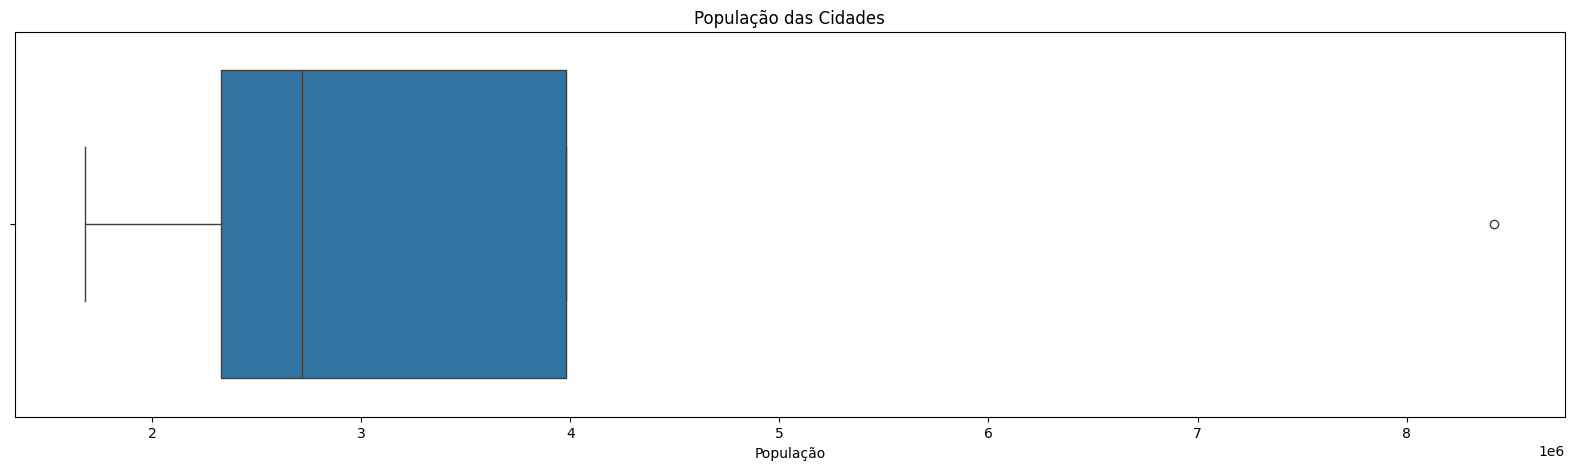

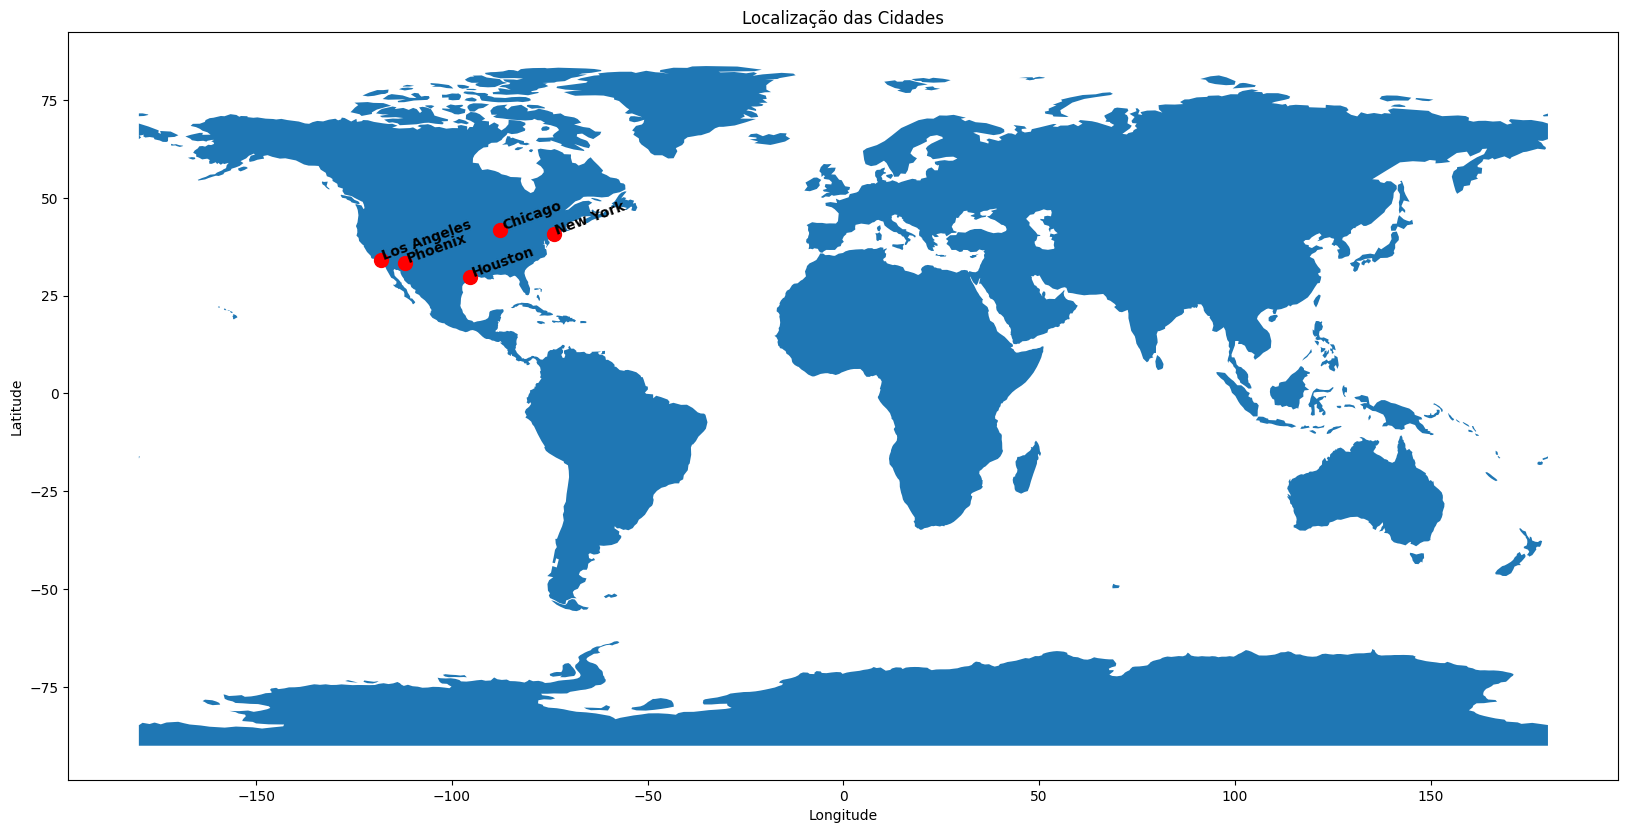

In [21]:
plt.figure(figsize = (20, 5))

sb.boxplot(x = cities['city_pop'])
contextualize('População das Cidades', 'População', '')

geometry = [Point(coordinates) for coordinates in zip(cities['long'], cities['lat'])]
gdf = GeoDataFrame(cities, geometry = geometry)

ax = world.plot(figsize = (20, 10))
ax.set_title('Localização das Cidades')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf.plot(ax = ax, color = 'red', markersize = 100)
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['city']):
    ax.text(x, y, label, fontweight = 'bold', rotation = 20)

O único ponto que aparece como *outlier* no diagrama de caixa e bigodes é a população máxima no conjunto de cidades (8419600 habitantes) que, tal como observado anteriormente, está fora do intervalo inter-quartis para os dados desta coluna, mas este valor, relativo à cidade *New York* (como visto inicialmente), está correto, ou seja, corresponde à realidade, pelo que não deve ser corrigido.

A par disso, tal como é possível verificar através do mapa, as coordenadas geográficas das cidades parecem estar aproximadamente corretas, isto é, situadas nos Estados Unidos da América e, por isso, com correspondência com a realidade.

Dado o conjunto de clientes, pode visualizar-se a sua distribuição por cidade, por profissão e por idade (derivada a partir da data de nascimento), distinguindo entre os dois géneros possíveis, na tentativa de encontrar algum padrão significativo nos dados, ou seja, procurar respostas para as perguntas **"Existe algum padrão na distribuição de clientes por cidade? E por profissão? E por idade?"**.

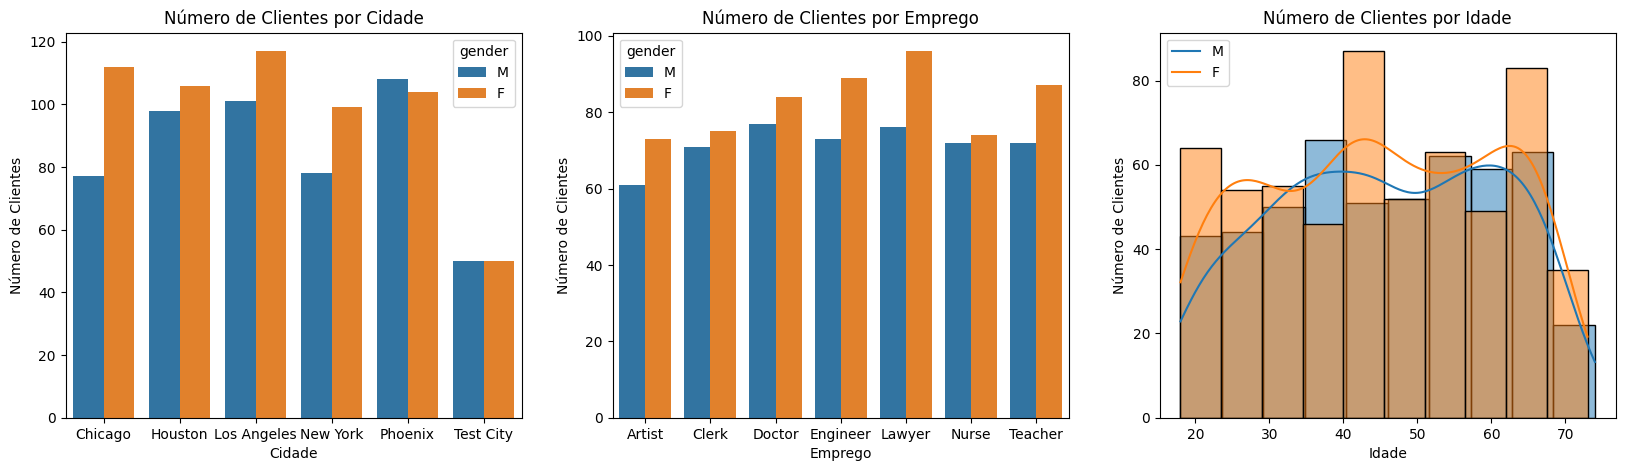

In [22]:
customers['age'] = pd.to_datetime('today').year - pd.to_datetime(customers['dob']).dt.year

plt.figure(figsize = (20, 5))

plt.subplot(1, 3, 1)
sb.countplot(customers, x = 'city', hue = 'gender', order = sorted(customers['city'].dropna().unique()))
contextualize('Número de Clientes por Cidade', 'Cidade', 'Número de Clientes')

plt.subplot(1, 3, 2)
sb.countplot(customers, x = 'job', hue = 'gender', order = sorted(customers['job'].dropna().unique()))
contextualize('Número de Clientes por Emprego', 'Emprego', 'Número de Clientes')

plt.subplot(1, 3, 3)
sb.histplot(customers[customers['gender'] == 'M']['age'], label = 'M', bins = 10, kde = True)
sb.histplot(customers[customers['gender'] == 'F']['age'], label = 'F', bins = 10, kde = True)
plt.legend(plt.gca().get_legend_handles_labels()[1])
contextualize('Número de Clientes por Idade', 'Idade', 'Número de Clientes')

Observando os três gráficos acima, a distribuição dos dados não parece ter nenhum aspeto a salientar, destacando-se apenas a cidade *Test City* como sendo aquela que não se encontra no conjunto de cidades com informação detalhada, cuja existência já fora constatada previamente.
Posteriormente, poderá ser relevante explorar com mais detalhe esta cidade para perceber se tem algum significado de relevo.

Pode, ainda, comparar-se a distribuição dos clientes por idade com uma distribuição normal, para perceber quão próximas estão ou quão semelhantes são estas distribuições. Esta análise pode ser efetuada através da visualização da própria distribuição dos clientes por idade, bem como de um gráfico quantil-quantil (Q-Q).

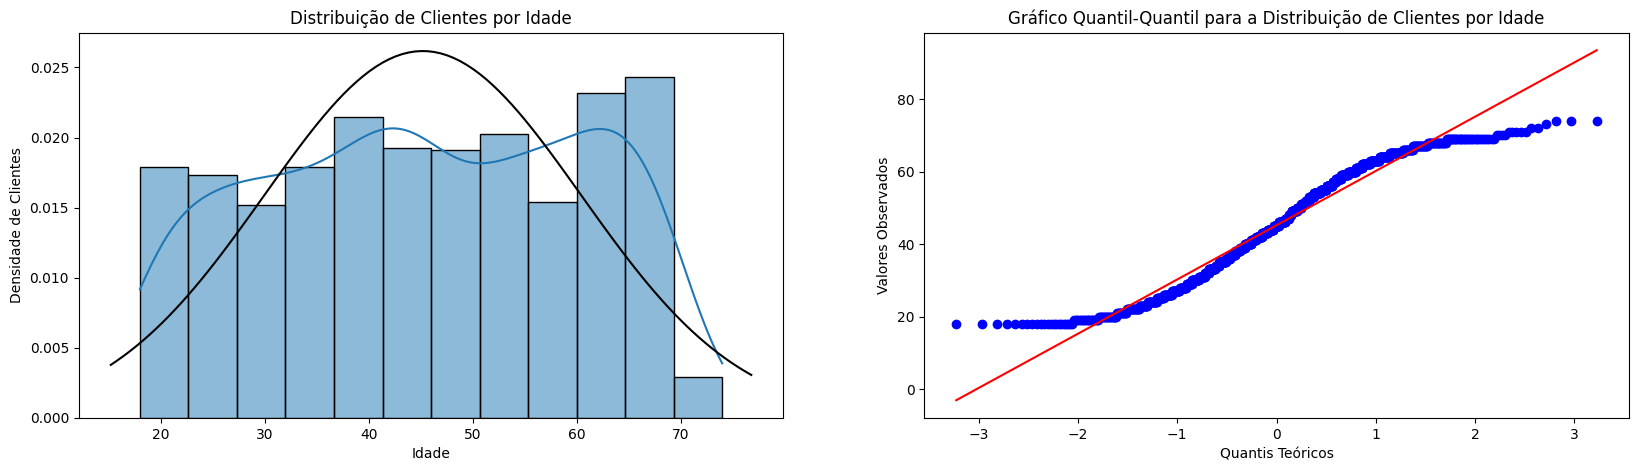

In [23]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
sb.histplot(customers['age'], stat = 'density', kde = True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, customers['age'].mean(), customers['age'].std())
plt.plot(x, p, 'k')
contextualize('Distribuição de Clientes por Idade', 'Idade', 'Densidade de Clientes')

plt.subplot(1, 2, 2)
stats.probplot(customers['age'], dist = 'norm', plot = plt)
contextualize('Gráfico Quantil-Quantil para a Distribuição de Clientes por Idade', 'Quantis Teóricos', 'Valores Observados')
plt.show()

A análise dos gráficos permite concluir que a distribuição de clientes por idade não segue uma distribuição normal, nem sequer se aproximando ou sendo semelhante a esta. Isto porque, no gráfico da esquerda, a curva da distribuição não é semelhante à curva de uma distribuição normal e, no gráfico da direita, os pontos apresentados não estão próximos da linha reta correspondente à distribuição normal.

Para além disto, é possível comprovar/fortalecer esta conclusão com recurso à computação de métricas e à realização de testes estatísticos. Assim, considere-se o teste cuja hipótese nula é "A distribuição de clientes por idade segue uma distribuição normal".

In [24]:
statistic, p_value = shapiro(customers['age'])
print('Shapiro-Wilk - Valor-P: {:.2f}'.format(p_value))

statistic, p_value = normaltest(customers['age'])
print('Agostino-Pearson - Valor-P: {:.2f}'.format(p_value))

print('Assimetria: {:.2f}'.format(skew(customers['age'])))
print('Curtose: {:.2f}'.format(kurtosis(customers['age'], fisher = False)))

customers = customers.drop('age', axis = 1)

Shapiro-Wilk - Valor-P: 0.00
Agostino-Pearson - Valor-P: 0.00
Assimetria: -0.08
Curtose: 1.84


Efetivamente, os valores-p obtidos extremamente próximos de 0 - portanto, menores do que 0.01 - permitem refutar a hipótese nula com 99% de confiança, assim como os resultados calculados para a assimetria (diferente de 0) e para a curtose (distante de 3) das idades dos clientes, complementam e consolidam a conclusão de que a distribuição de clientes por idade não segue nem se aproxima de uma distribuição normal.

Por isso, como a distribuição de clientes por idade não está próxima de uma distribuição normal, se se optar por normalizar este atributo, o método correto é *Min-Max Scaling* e não *Standard Scaling*.

Considerando o conjunto de comerciantes, pode ser relevante visualizar a sua distribuição por categoria e a localização no mapa.

Enquanto a distribuição por categoria visa apenas - tal como anteriormente - procurar a existência de algum padrão que se saliente nos dados, a localização geográfica dos comerciantes pode ser importante para perceber se existe alguma relação entre essa informação e a legitimidade das transações efetuadas em cada um deles.

Tendo em conta que, por um lado, todos os clientes (à exceção dos residentes em *Test City*) pertencem a cidades nos Estados Unidos da América, mas, por outro lado, muitos comerciantes não se encontram nos Estados Unidos da América, pode haver alguma relação entre a localização geográfica do comerciante e a legitimidade de uma transação a ele associada, tal como, por exemplo, uma transação ser mais provavelmente fraudulenta se tiver sido efetuada num comerciante fora dos Estados Unidos da América.

Em suma, procura-se solucionar as questões **"Existe algum destaque na distribuição dos comerciantes por categoria?"** e **"Poderá haver alguma importância na localização de um comerciante para a classificação de uma transação como fraudulenta ou legítima?"**.

<Axes: title={'center': 'Localização dos Comerciantes'}, xlabel='Longitude', ylabel='Latitude'>

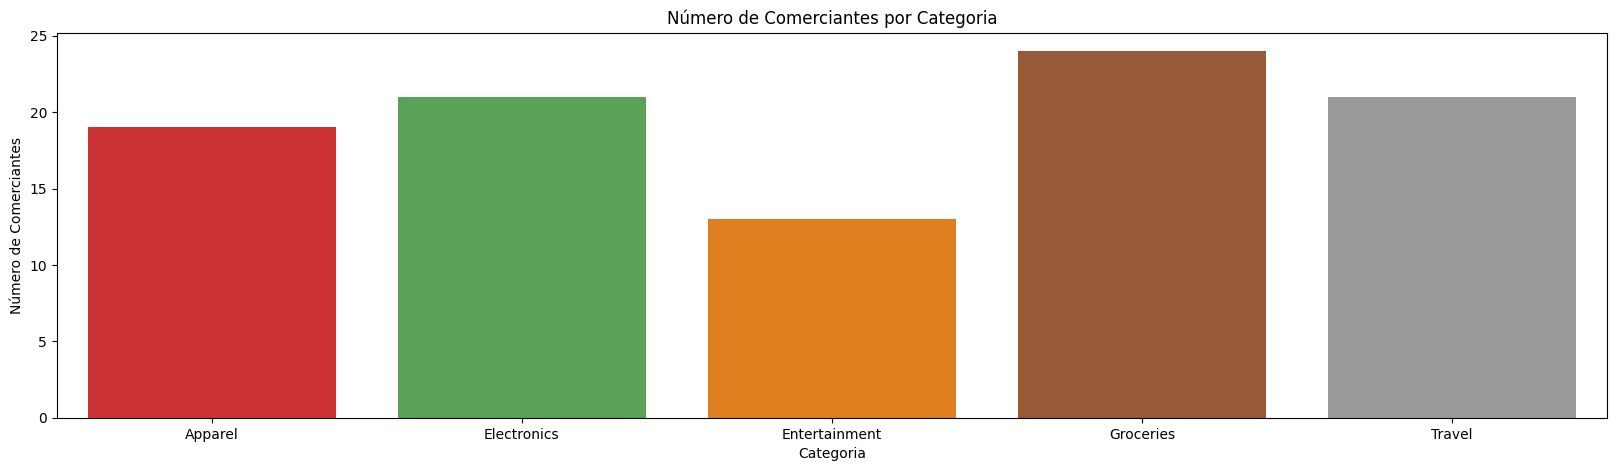

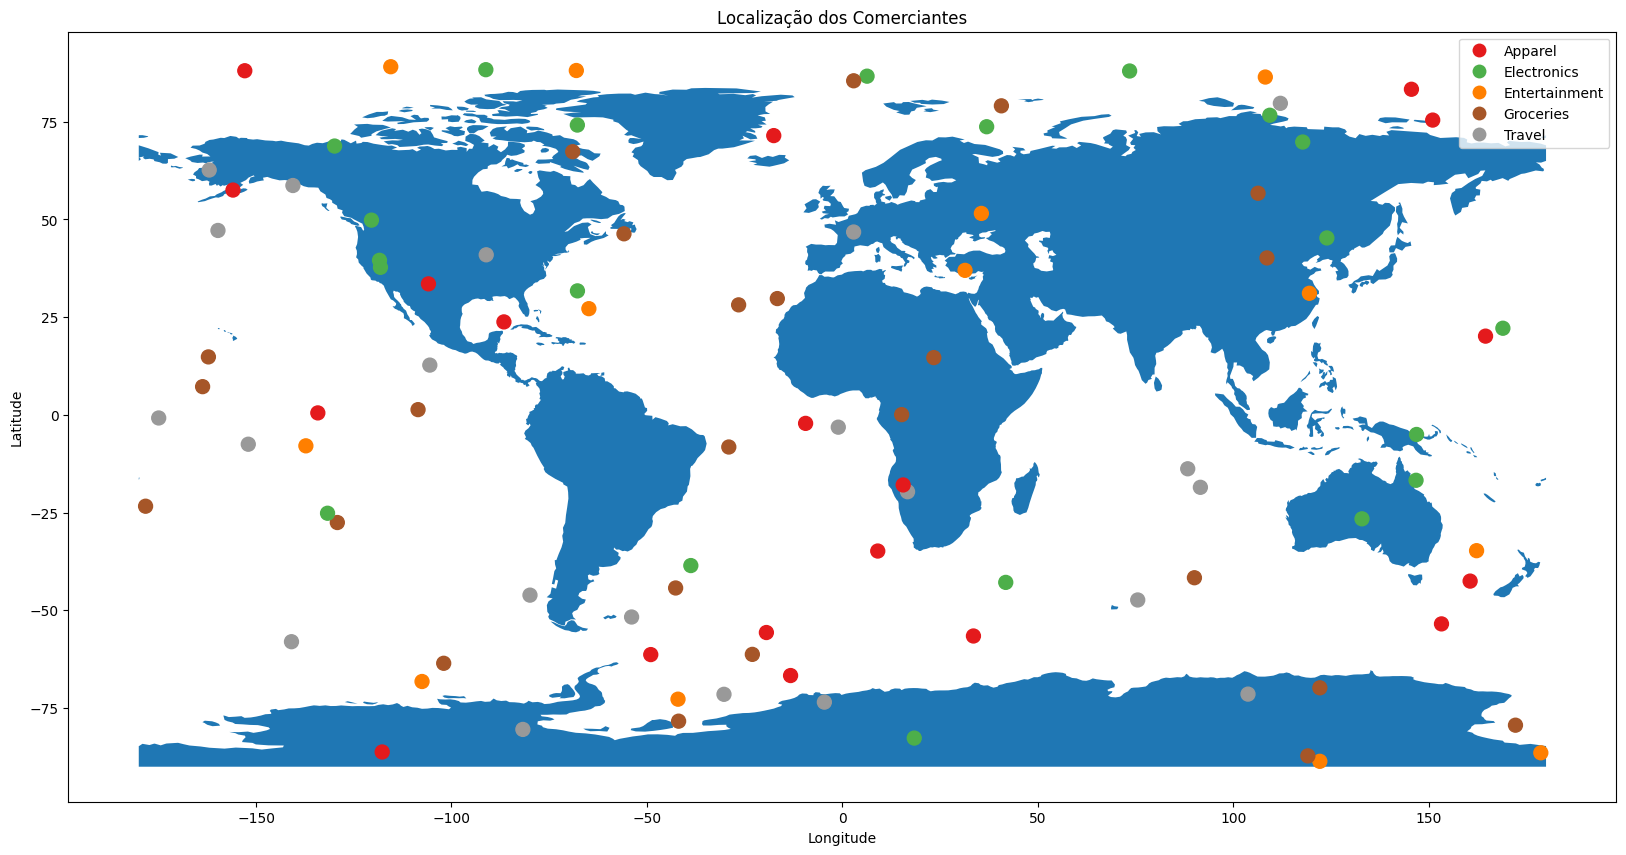

In [25]:
plt.figure(figsize = (20, 5))

sb.countplot(merchants, x = 'category', palette = {'Apparel': '#e41a1c', 'Electronics': '#4daf4a', 'Entertainment': '#ff7f00', 'Groceries': '#a65628', 'Travel': '#999999'}, order = sorted(merchants['category'].dropna().unique()))
contextualize('Número de Comerciantes por Categoria', 'Categoria', 'Número de Comerciantes')

geometry = [Point(coordinates) for coordinates in zip(merchants['merch_long'], merchants['merch_lat'])]
gdf = GeoDataFrame(merchants, geometry = geometry)

ax = world.plot(figsize = (20, 10))
ax.set_title('Localização dos Comerciantes')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf.plot(ax = ax, column = 'category', cmap = 'Set1', legend = True, markersize = 100)

Ao observar a distribuição dos comerciantes por categoria, não se destaca nenhum padrão que permita extrair qualquer informação/conclusão.

Contudo, visualizando a localização geográfica dos comerciantes no mapa, observa-se que as coordenadas de muitos comerciantes remetem para lugares que se encontram no oceano, ou seja, em localizações impossíveis para um comerciante.
Assim sendo, assume-se que a localização não é uma informação confiável, pelo que deverá vir a ser descartada posteriormente.

No caso do conjunto de transações, existem vários gráficos que se devem explorar, para tentar encontrar respostas a várias questões.

Em particular, pode procurar-se algum padrão na distribuição de transações fraudulentas por hora, ou por dia da semana, ou por mês - **"Existe algum padrão na distribuição de transações (fraudulentas) por hora? E por dia? E por mês?"**.

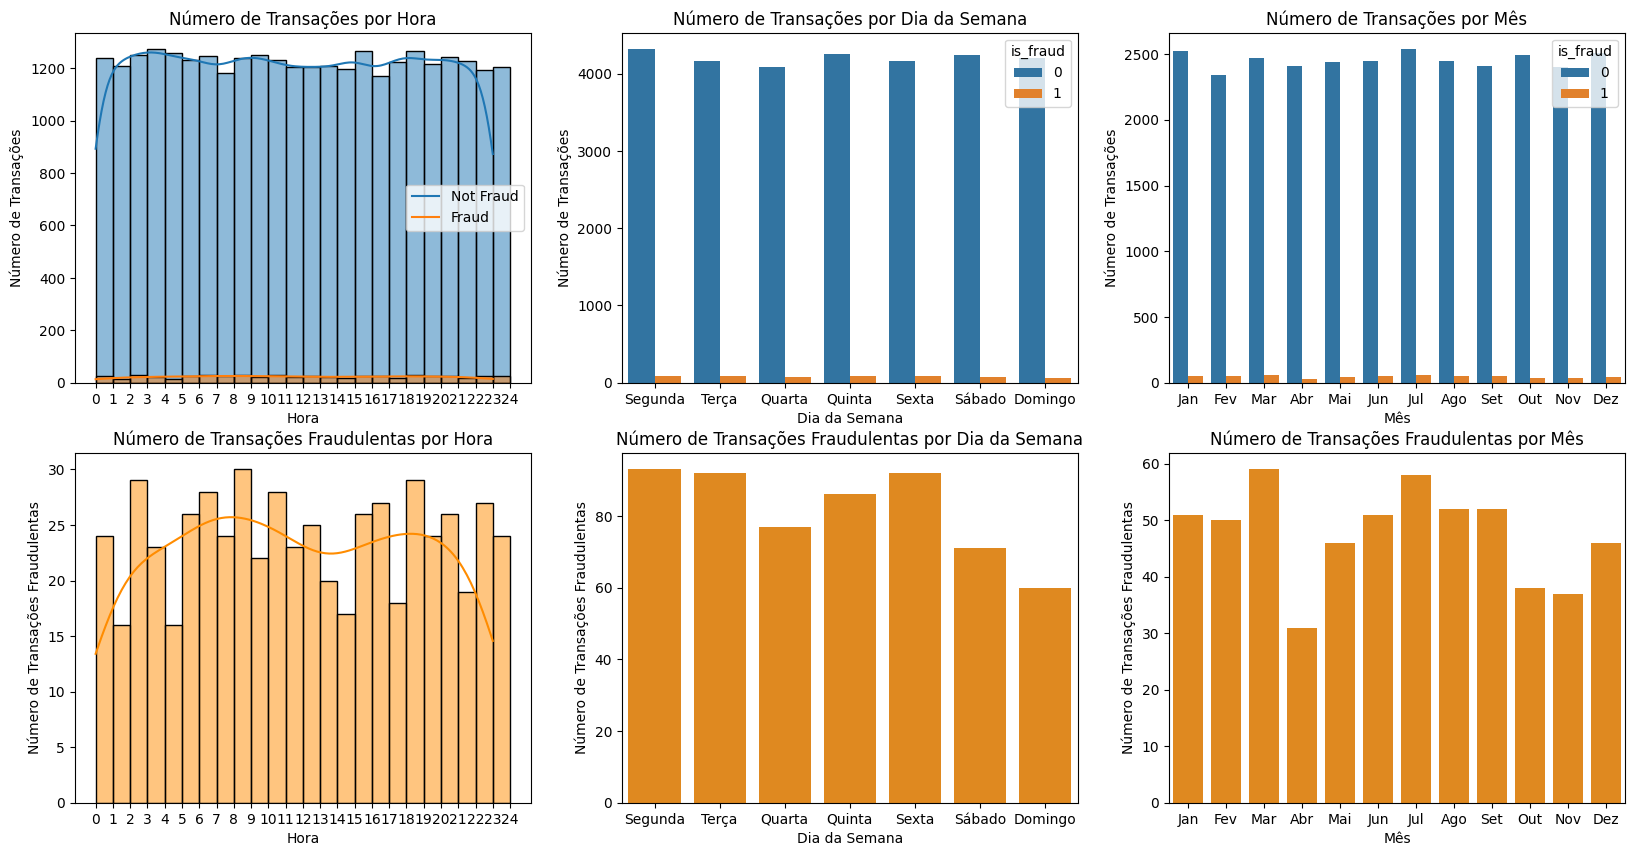

In [26]:
transactions['hour'] = pd.to_datetime(transactions['unix_time'], unit = 's').dt.hour
transactions['weekday'] = pd.to_datetime(transactions['unix_time'], unit = 's').dt.weekday
transactions['month'] = pd.to_datetime(transactions['unix_time'], unit = 's').dt.month

plt.figure(figsize = (20, 10))

plt.subplot(2, 3, 1)
sb.histplot(transactions[transactions['is_fraud'] == 0]['hour'], label = 'Not Fraud', bins = range(25), kde = True)
sb.histplot(transactions[transactions['is_fraud'] == 1]['hour'], label = 'Fraud', bins = range(25), kde = True)
plt.legend(plt.gca().get_legend_handles_labels()[1])
plt.xticks(range(25))
contextualize('Número de Transações por Hora', 'Hora', 'Número de Transações')

plt.subplot(2, 3, 2)
sb.countplot(transactions, x = 'weekday', hue = 'is_fraud', order = sorted(transactions['weekday'].dropna().unique()))
plt.xticks(ticks = range(7), labels = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'])
contextualize('Número de Transações por Dia da Semana', 'Dia da Semana', 'Número de Transações')

plt.subplot(2, 3, 3)
sb.countplot(transactions, x = 'month', hue = 'is_fraud', order = sorted(transactions['month'].dropna().unique()))
plt.xticks(ticks = range(12), labels = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
contextualize('Número de Transações por Mês', 'Mês', 'Número de Transações')

plt.subplot(2, 3, 4)
sb.histplot(transactions[transactions['is_fraud'] == 1]['hour'], bins = range(25), kde = True, color = 'darkorange')
plt.xticks(range(25))
contextualize('Número de Transações Fraudulentas por Hora', 'Hora', 'Número de Transações Fraudulentas')

plt.subplot(2, 3, 5)
sb.countplot(transactions[transactions['is_fraud'] == 1], x = 'weekday', color = 'darkorange', order = sorted(transactions['weekday'].dropna().unique()))
plt.xticks(ticks = range(7), labels = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'])
contextualize('Número de Transações Fraudulentas por Dia da Semana', 'Dia da Semana', 'Número de Transações Fraudulentas')

plt.subplot(2, 3, 6)
sb.countplot(transactions[transactions['is_fraud'] == 1], x = 'month', color = 'darkorange', order = sorted(transactions['month'].dropna().unique()))
plt.xticks(ticks = range(12), labels = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
contextualize('Número de Transações Fraudulentas por Mês', 'Mês', 'Número de Transações Fraudulentas')

transactions = transactions.drop('hour', axis = 1)
transactions = transactions.drop('weekday', axis = 1)
transactions = transactions.drop('month', axis = 1)

Efetivamente, desprezando ligeiras flutuações, não se consegue extrair nenhuma conclusão significativa da análise deste gráficos.

Verifica-se uma tendência de existirem alguns intervalos de horas com menos transações fraudulentas, bem como uma menor ocorrência das mesmas ao fim de semana (principalmente ao domingo) e no mês de abril, mas estas informações não parecem ser muito relevantes por não se salientarem de forma extremamente evidente, nem parecer haver uma justificação lógica para as mesmas que não seja serem puramente fruto do acaso.

Ainda assim, a discriminação de cada transação na sua hora, dia, mês e dia da semana pode ser relevante para o modelo extrair conclusões sobre a legitimidade da transação.

Pode ainda ser interessante verificar se existe alguma relação entre a legitimidade de uma transação e o sistema operativo associado ao dispositivo em que foi efetuada, bem como relativamente à quantia das mesmas - **"Será que o sistema operativo pode auxiliar na classificação de uma transação como fraudulenta? E a quantia?"**.

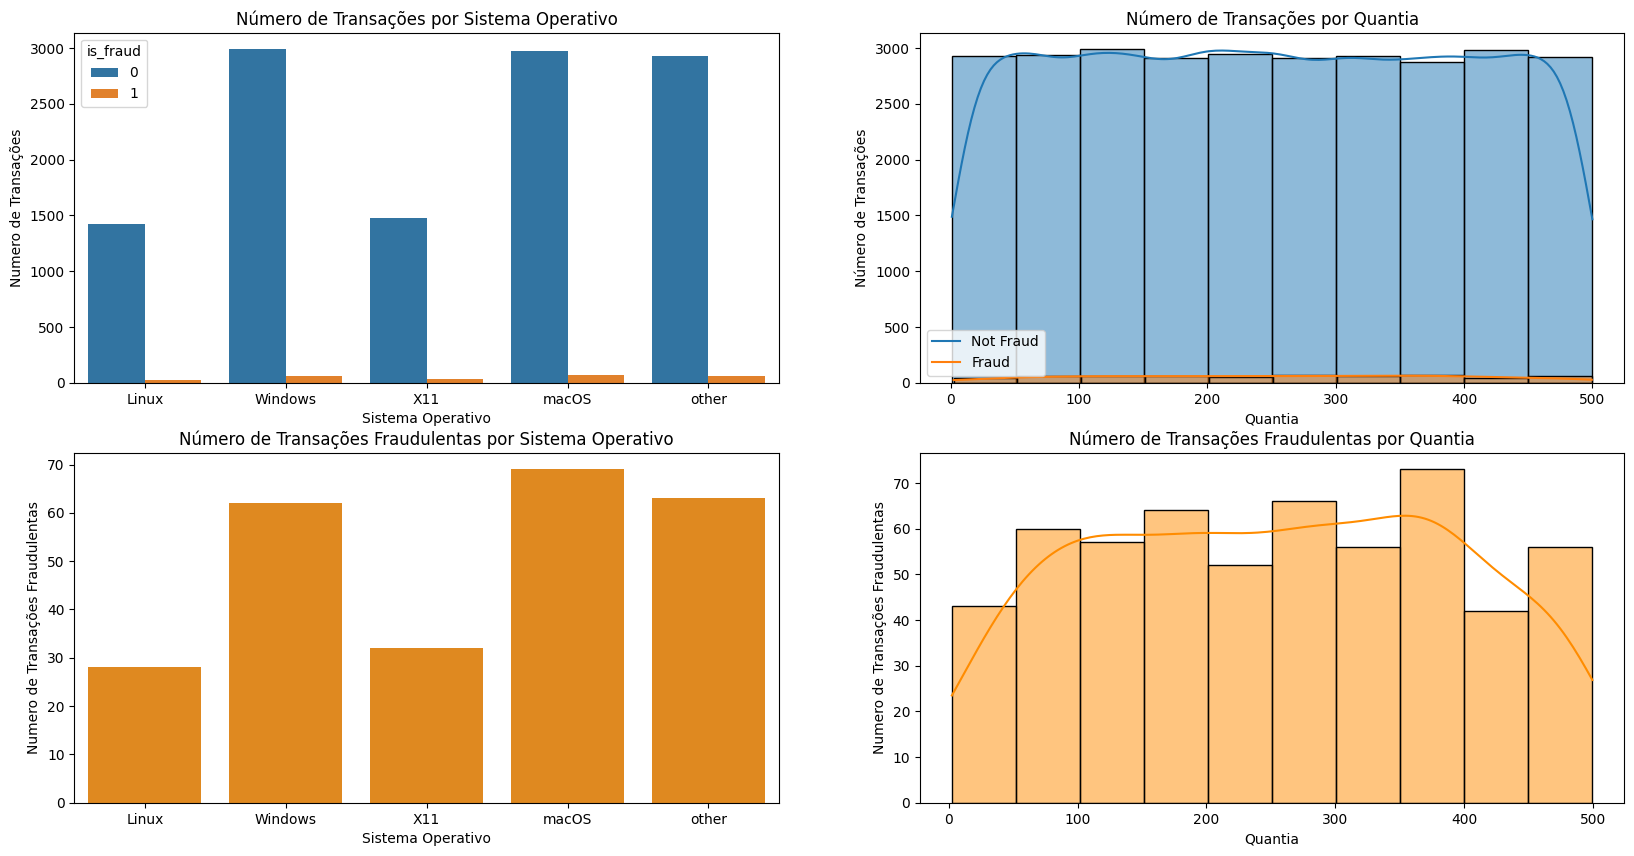

In [27]:
plt.figure(figsize = (20, 10))

plt.subplot(2, 2, 1)
sb.countplot(transactions, x = 'device_os', hue = 'is_fraud', order = sorted(transactions['device_os'].dropna().unique()))
contextualize('Número de Transações por Sistema Operativo', 'Sistema Operativo', 'Numero de Transações')

plt.subplot(2, 2, 2)
sb.histplot(transactions[transactions['is_fraud'] == 0]['amt'], label = 'Not Fraud', bins = 10, kde = True)
sb.histplot(transactions[transactions['is_fraud'] == 1]['amt'], label = 'Fraud', bins = 10, kde = True)
plt.legend(plt.gca().get_legend_handles_labels()[1])
contextualize('Número de Transações por Quantia', 'Quantia', 'Número de Transações')

plt.subplot(2, 2, 3)
sb.countplot(transactions[transactions['is_fraud'] == 1], x = 'device_os', color = 'darkorange', order = sorted(transactions['device_os'].dropna().unique()))
contextualize('Número de Transações Fraudulentas por Sistema Operativo', 'Sistema Operativo', 'Numero de Transações Fraudulentas')

plt.subplot(2, 2, 4)
sb.histplot(transactions[transactions['is_fraud'] == 1]['amt'], bins = 10, kde = True, color = 'darkorange')
contextualize('Número de Transações Fraudulentas por Quantia', 'Quantia', 'Numero de Transações Fraudulentas')

Contudo, ao observar os gráficos desenhados, também não parece haver nenhuma relação muito evidente entre o sistema operativo e a legitimidade de uma transação.

Quanto à quantia, a única conclusão que se pode extrair é que parece existir uma tendência para as transações fraudulentas estarem associadas a montantes medianos (entre os 100 e os 400), isto é, nem extremamente baixos (< 100), nem extremamente altos (> 400).

A explicação para isto pode residir em dois fatores. Por um lado, na perspetiva de um atacante, uma transação fraudulenta de quantia reduzida pode não compensar/justificar o risco de ser apanhado. Por outro lado, admitindo que uma transação de quantia elevada é mais escrutinada, um atacante pode também considerar que tentar uma transação fraudulenta acima de um dado valor será demasiado arriscado e aumentará a probabilidade de ser detetado. Por isso, poderá haver uma tendência para as transações fraudulentas estarem associadas a montantes suficientemente elevados para justificarem o risco que lhes é inerente, mas suficientemente reduzidos para não serem demasiado arriscadas.

Para além disto, é também possível verificar a distribuição das transações por quantia de maneira a compará-la com uma distribuição normal para compreender se existe alguma semelhança ou aproximação entre estas duas distribuições. Isto pode ser analisado por meio da visualização da distribuição das transações por quantia e de um gráfico quantil-quantil (Q-Q).

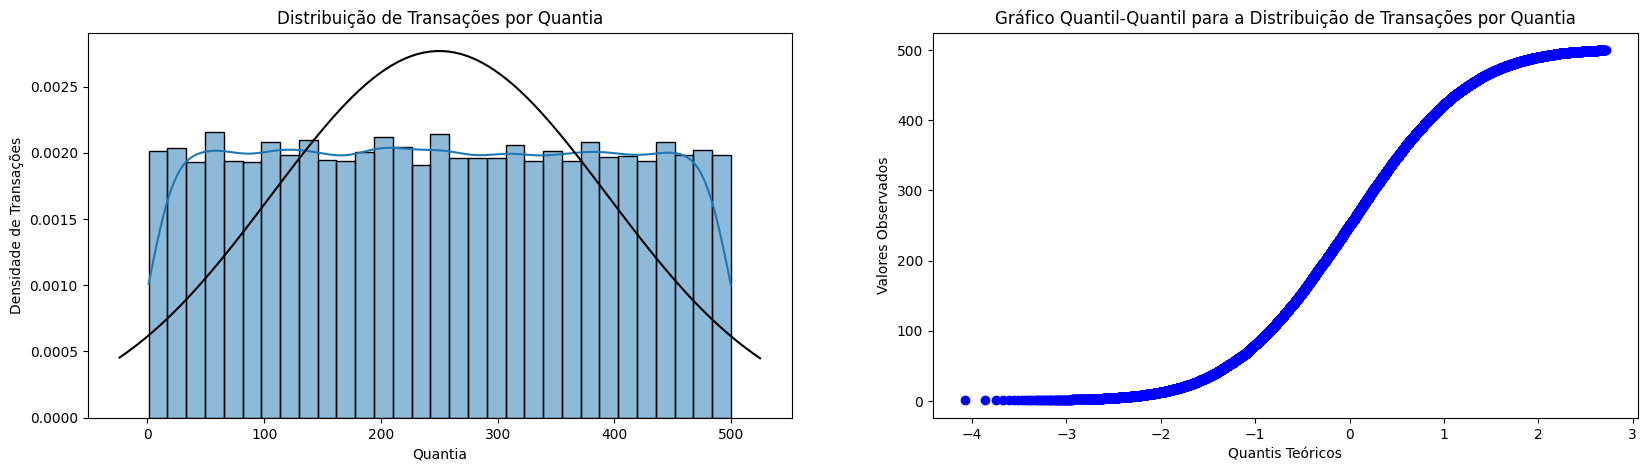

In [28]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
sb.histplot(transactions['amt'], stat = 'density', kde = True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, transactions['amt'].mean(), transactions['amt'].std())
plt.plot(x, p, 'k')
contextualize('Distribuição de Transações por Quantia', 'Quantia', 'Densidade de Transações')

plt.subplot(1, 2, 2)
stats.probplot(transactions['amt'], dist = 'norm', plot = plt)
contextualize('Gráfico Quantil-Quantil para a Distribuição de Transações por Quantia', 'Quantis Teóricos', 'Valores Observados')
plt.show()

Ambos os gráficos evidenciam que a distribuição de transações por quantia não está próxima de uma distribuição normal, visto que a curva da distribuição é bastante diferente da curva correspondente a uma distribuição normal e o traçado no gráfico quantil-quantil também não se aproxima de uma linha reta, tal como seria o caso numa distribuição normal.

A par disto, este facto pode ser consolidado através de algumas métricas e do resultado de testes estatísticos. Tal como anteriormente, a hipótese nula dos testes de hipóteses é "A distribuição de transações por quantia segue uma distribuição normal".

In [29]:
amt = transactions['amt'].dropna()

statistic, p_value = shapiro(amt)
print('Shapiro-Wilk - Valor-P: {:.2f}'.format(p_value))

statistic, p_value = normaltest(amt)
print('Agostino-Pearson - Valor-P: {:.2f}'.format(p_value))

print('Assimetria: {:.2f}'.format(skew(amt)))
print('Curtose: {:.2f}'.format(kurtosis(amt, fisher = False)))

Shapiro-Wilk - Valor-P: 0.00
Agostino-Pearson - Valor-P: 0.00
Assimetria: 0.00
Curtose: 1.80


Deste modo, como os valores-p resultantes dos testes de hipóteses estão extremamente perto de 0, sendo, portanto, menores do que 0.01, é possível refutar a hipótese nula com uma confiança de 99%. Além disto, o valor obtido para a curtose (diferente de 3) sustenta a conclusão de que a distribuição de transações por quantia não é uma distribuição normal.

Como tal, estando garantido que a distribuição de transações por quantia não segue nem se aproxima de uma distribuição normal, caso seja necessário normalizar esta variável, a abordagem correta é utilizar *Min-Max Scaling*.

Pode também ser relevante procurar alguma ligação entre as transações fraudulentas e determinados comerciantes - **"Há alguma ligação entre a legitimidade de uma transação e o comerciante em que é efetuada?"**.

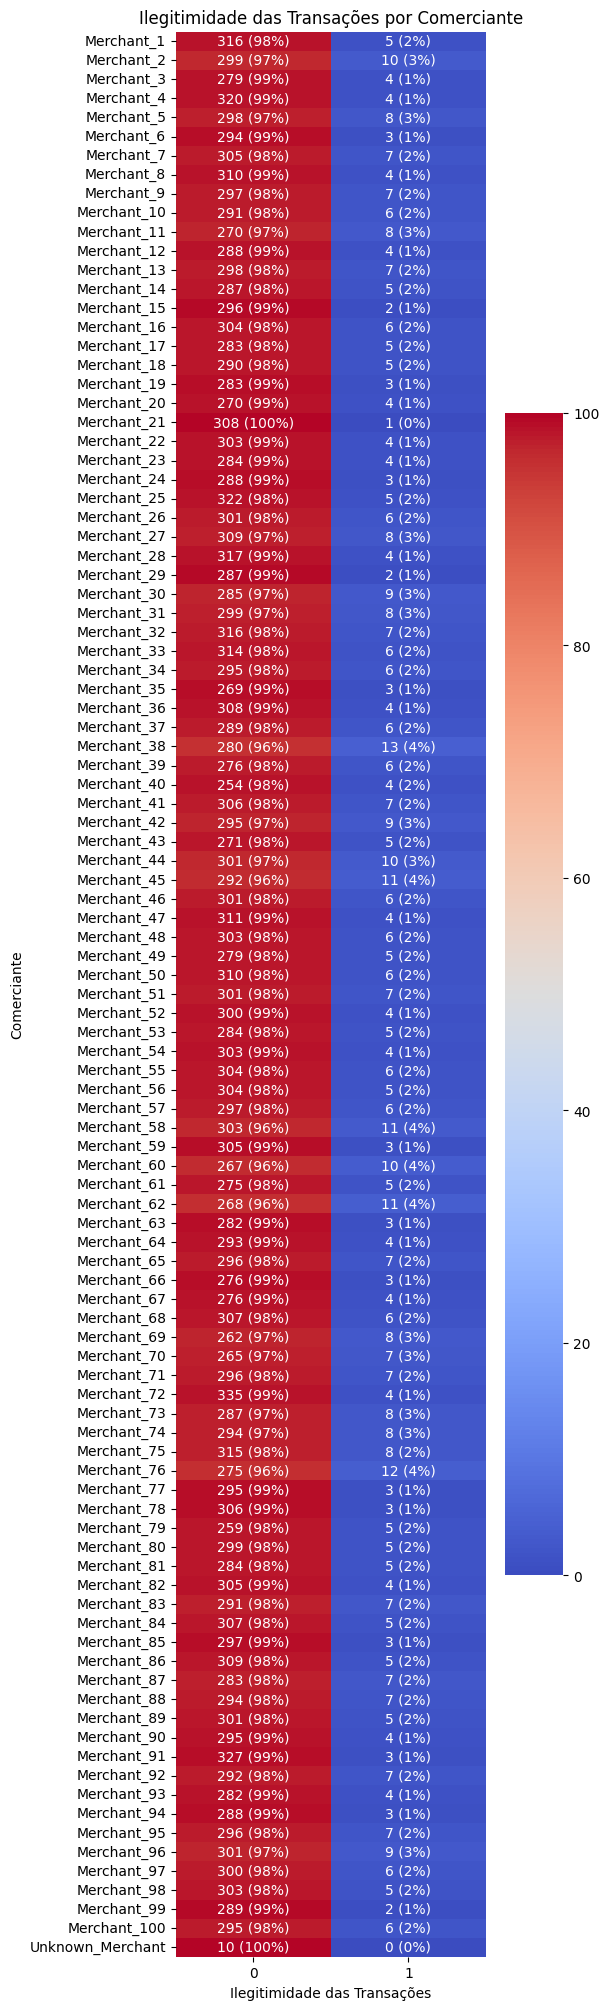

In [30]:
plt.figure(figsize = (5, 25))

table = pd.crosstab(transactions['merchant'], transactions['is_fraud'])
table = table.sort_values(by = 'merchant', key = lambda x: x.str.split('_').str[1].apply(lambda val: int(val) if val.isdigit() else float('inf')))
row_sum = table.sum(axis = 1)
percentages = (table.T / row_sum * 100).T
annotations = [['{} ({}%)'.format(count, round(percentage)) for percentage, count in zip(row, table_row)] for table_row, row in zip(table.values, percentages.values)]
sb.heatmap(percentages, annot = annotations, fmt = '', cmap = 'coolwarm')
contextualize('Ilegitimidade das Transações por Comerciante', 'Ilegitimidade das Transações', 'Comerciante')

Ao analisar o gráfico acima, podem extrair-se duas conclusões.

Em primeiro lugar, o comerciante *Unknown_Merchant* é aquele - cuja existência já fora identificada anteriormente - que não se encontra mapeado no conjunto de comerciantes com informação detalhada.
Em segundo lugar, observa-se também que este é o único comerciante que não tem nenhuma transação fraudulenta associada, sendo legítimas todas as transações nele efetuadas.

Para além disto, não se observa mais nenhuma relação significativa entre transações fraudulentas e determinados comerciantes, tendo todos um rácio de transações fraudulentas que se encontra entre 1% e 4%.

Finalmente, pode existir alguma correlação significativa entre as variáveis, identificável através de um correlograma - **"Algum atributo está fortemente correlacionado com a legitimidade de uma transação?"**.

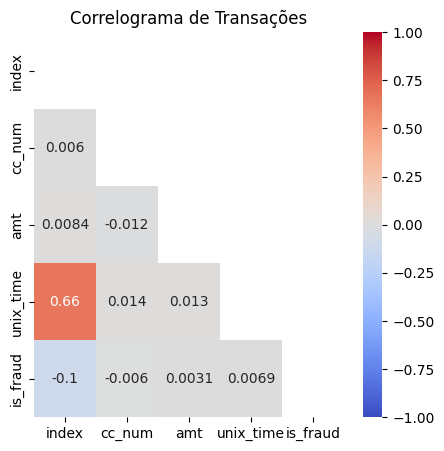

In [31]:
correlation = transactions.select_dtypes(['float', 'int']).corr()

plt.figure(figsize = (5, 5))
sb.heatmap(correlation, annot = True, cmap = 'coolwarm', mask = np.triu(np.ones_like(correlation, dtype = bool)), vmin = -1, vmax = 1)
contextualize('Correlograma de Transações', '', '')

No correlograma, existem apenas duas células que se destacam visualmente: (*unix_time*, *index*) com um coeficiente de correlação de 0,66 e (*is_fraud*, *index*) com um coeficiente de correlação de -0,1.

Contudo, como o atributo *index* é simplesmente o índice da transação, sendo, por isso, meramente indicativo e não informativo, não se pode extrair nada de significativo destas correlações. Efetivamente, o atributo *index* será, numa fase posterior, removido do conjunto de dados.

Assim, não se identifica nenhuma correlação relevante entre os atributos analisados para o conjunto de transações.

Em suma, extraem-se as seguintes conclusões desta fase:

- O conjunto de cidades parece conter dados corretos e plausíveis;
- No conjunto de clientes, o único fator de relevo é a existência de uma cidade *Test City*, que não se encontra mapeada no conjunto de cidades;
- No conjunto de comerciantes, a localização geográfica não parece ser uma informação credível, por remeter para demasiados pontos inviáveis/impossíveis, pelo que deverá ser desconsiderada;
- No conjunto de transações:
  - O único padrão/tendência que pode ter algum significado relevante é o facto de haver mais transações fraudulentas com quantias entre os 100 e os 400, em comparação com as transações de montantes fora deste intervalo;
  - Existe um comerciante *Unknown_Merchant* que é o único que só tem associadas transações legítimas;
  - Não existem correlações evidentes de alguma variável com a variável-alvo (*is_fraud*).

### Verificação da Qualidade dos Dados

Antes de preparar os dados para a sua ingestão por parte do modelo, deve aferir-se a sua qualidade, em particular quanto a valores em falta, valores duplicados/redundantes, erros (de codificação ou de medição), ou inconsistências, entre outros.

Note-se que as funções `pandas.DataFrame.isna()` e `pandas.DataFrame.isnull()` são estritamente equivalentes, isto é, têm exatamente o mesmo significado e realizam exatamente o mesmo, pelo que só se utilizará uma delas.

In [32]:
cities.isnull().sum()

city        0
lat         0
long        0
city_pop    0
state       0
dtype: int64

Deste modo, verifica-se que não existem valores em falta no conjunto de cidades.

In [33]:
customers.isnull().sum()

cc_num     0
first      0
last       0
gender     0
street     0
city       0
zip       20
job       20
dob        0
dtype: int64

No conjunto de clientes, existem 20 clientes cujo código-postal e/ou profissão estão em falta, pelo que esses casos devem ser observados de forma mais detalhada.

In [34]:
customers[customers.isnull().any(axis = 1)]

,cc_num,first,last,gender,street,city,zip,job,dob
6,2801374844713453,Jane,Smith,F,1st Ave,Chicago,NaN,NaN,2002-10-12
49,3995222018549835,Alice,Jones,F,1st Ave,Los Angeles,NaN,NaN,1970-04-07
104,6595820336089781,John,Smith,M,1st Ave,New York,NaN,NaN,1969-02-09
133,6715685094256252,Joe,Davis,F,Elm St,Los Angeles,NaN,NaN,1964-01-01
142,6456820738894681,Bob,Jones,M,2nd Ave,Chicago,NaN,NaN,1963-01-07
242,8380676395244843,Joe,Clark,F,2nd Ave,New York,NaN,NaN,1968-02-21
262,2943708768126750,John,Davis,F,2nd Ave,Chicago,NaN,NaN,1997-06-30
318,4095489114638262,Mike,Johnson,M,Broadway,New York,NaN,NaN,1955-05-11
345,9522441117141112,Mike,Williams,M,Broadway,New York,NaN,NaN,1981-05-03
368,1001431780128805,John,Clark,F,Main St,Chicago,NaN,NaN,1993-07-11


Tal como é possível observar, todos os clientes com código-postal em falta também têm a profissão em falta e vice-versa. Ora, não sendo recomendável eliminar clientes por serem uma parte fundamental da transação, a decisão a tomar deve ser ponderada.

O atributo *zip* - categórico nominal - será posteriormente removido, dado que, para além de não demonstrar ser relevante para a decisão da variável-alvo, a sua codificação resultaria num aumento substancial do número de colunas a tratar pelo modelo, correndo o risco de degradar substancialmente o seu desempenho.

Quando ao atributo *job*, os valores em falta serão imputados com o valor mais comum para o género e a cidade do cliente, de maneira a tentar preservar tanto quanto possível as propriedades do conjunto inicial de dados.

In [35]:
merchants.isnull().sum()

merchant       0
category       2
merch_lat      2
merch_long     0
merchant_id    0
dtype: int64

No conjunto de comerciantes, apenas existem 2 comerciantes com valores em falta (categoria e latitude), pelo que serão analisados.

In [36]:
merchants[merchants.isnull().any(axis = 1)]

,merchant,category,merch_lat,merch_long,merchant_id
80,Merchant_81,NaN,NaN,-20.261696,81
84,Merchant_85,NaN,NaN,76.433212,85


De forma análoga à anterior, os comerciantes com a categoria em falta também têm a latitude em falta e vice-versa. Ora, tal como anteriormente, estas linhas não devem ser eliminadas, visto que os comerciantes são elementos essenciais de cada transação, pelo que se deve deliberar a ação a efetuar.

A coluna *merch_lat* já foi determinada como não confiável, o que leva a que os valores em falta nesta coluna não sejam problemáticos e não tenham necessidade de ser tratados, dado que a coluna será, posteriormente, eliminada.

A coluna *category* pode ser relevante para o modelo, de modo que os valores em falta devem ser imputados. Dada a escassez de atributos válidos para os comerciantes, o que inviabiliza uma imputação considerando os valores mais próximos/semelhantes, a imputação da categoria será feita com a categoria mais comum (a moda), à falta de melhor opção.

In [37]:
transactions.isnull().sum()

index                        0
trans_date_trans_time      100
cc_num                       0
device_os                17964
merchant                     0
amt                        100
trans_num                    0
unix_time                    0
is_fraud                     0
dtype: int64

Finalmente, o conjunto de transações é aquele que tem mais valores em falta e - dada a sua maior importância - deve ser alvo de uma análise mais aprofundada.

Os valores em falta na coluna *trans_date_trans_time* não são relevantes, porque esta coluna traduz a mesma informação que a coluna *unix_time* (é redundante), pelo que o atributo *trans_date_trans_time* será removido posteriormente, sem perda de informação.

In [38]:
transactions[transactions['amt'].isnull()][transactions['is_fraud'] == 1]

,index,trans_date_trans_time,cc_num,device_os,merchant,amt,trans_num,unix_time,is_fraud
9958,2452,NaN,8071385341284566,NaN,Merchant_44,NaN,TRANS_620131,1698667500,1
9968,3588,NaN,3622556887399519,other,Merchant_5,NaN,TRANS_471519,1685949525,1


Dos 100 valores em falta da coluna *amt*, apenas 2 correspondem a transações fraudulentas.

Uma destas duas transações tem em falta, para além da quantia, o valor do atributo *device_os*, pelo que a sua eliminação é a decisão mais adequada a tomar dado que, caso contrário, teriam de ser imputados valores em duas colunas.

In [39]:
transactions[transactions['trans_num'] == 'TRANS_471519']

,index,trans_date_trans_time,cc_num,device_os,merchant,amt,trans_num,unix_time,is_fraud
9968,3588,NaN,3622556887399519,other,Merchant_5,NaN,TRANS_471519,1685949525,1
24331,24331,2024-05-23 21:49:28.883202,4982979488642298,NaN,Merchant_56,353.56,TRANS_471519,1714024272,0


A outra transação com quantia em falta parece ser um erro, dado que existe uma outra transação com o mesmo número (que devia ser único), mas com dados totalmente diferentes. Como tal, para evitar introduzir erros no modelo, ambas as transações com o número *TRANS_471519* deverão ser eliminadas futuramente.

Assim, todas as 100 transações com o valor do atributo *amt* em falta podem ser eliminadas com segurança.

Por último, note-se que existem quase 18000 valores em falta na coluna *device_os*, o que corresponde a mais de metade do conjunto de transações (30000). Assim sendo, visto que (1) eliminar as linhas com valores em falta levaria a uma redução drástica do conjunto de dados para menos de metade do conjunto inicial e (2) este atributo não se mostrou ser relevante para o modelo, a decisão a tomar é remover a coluna *device_os*.

Concluída a análise sobre valores em falta, devem tambem procurar-se valores duplicados/redundantes e eventuais erros.

In [40]:
cities.nunique()

city        5
lat         5
long        5
city_pop    5
state       5
dtype: int64

No conjunto de cidades, todos os valores são únicos e a sua correção pode ser verificada através da observação de todos os valores, tendo em conta que são apenas 5.

In [41]:
cities

,city,lat,long,city_pop,state
0,Los Angeles,34.0522,-118.2437,3979576,CA
1,Houston,29.7604,-95.3698,2328000,TX
2,Phoenix,33.4484,-112.0740,1680992,AZ
3,Chicago,41.8781,-87.6298,2716000,IL
4,New York,40.7128,-74.0060,8419600,NY


Observando todos os valores presentes no conjunto de cidades e comparando-os com os dados reais, confirma-se que todos os valores estão corretos.

In [42]:
cities.duplicated().sum()

0

Efetivamente, confirma-se que não existem cidades duplicadas.

In [43]:
cities['city'].duplicated().sum()

0

Em particular, verifica-se também que não existem nomes de cidades duplicados, tal como esperado, tendo em conta que esta coluna deve corresponder à chave primária da tabela/relação.

In [44]:
customers.nunique()

cc_num    1100
first      108
last       108
gender       2
street     102
city         6
zip       1077
job          7
dob       1062
dtype: int64

No conjunto de clientes, verifica-se que apenas existem 108 nomes e 108 apelidos, o que não parece plausível para 1100 pessoas. Isto poderá significar que os nomes e apelidos foram modificados para garantir o anonimato dos clientes, o que dá mais força à teoria de serem atributos irrelevantes para o modelo, pelo que podem e devem ser removidos posteriormente.

De forma análoga, 102 moradas distintas parece um valor extremamente pequeno para 1100 pessoas, o que deverá ser um indicativo do mesmo facto, isto é, de que as moradas foram alteradas para assegurar o anonimato dos clientes e, por isso, este é mais um atributo sem relevância para o modelo, pelo que deve ser eliminado posteriormente.

Em sentido inverso, o número de códigos-postais únicos e de datas de nascimento únicas parece plausível, ainda que isso não signifique que são atributos relevantes, mas apenas que os seus valores deverão estar corretos.

In [45]:
customers['gender'].unique()

array(['M', 'F'], dtype=object)

Os valores para o género também estão corretos, de acordo com a representação esperada (*M* para masculino e *F* para feminino).

In [46]:
customers['city'].unique()

array(['Los Angeles', 'Houston', 'Phoenix', 'Chicago', 'New York',
       'Test City'], dtype=object)

Na coluna *city*, tal como verificado anteriormente no gráfico "Numero de Clientes por Cidade", destaca-se apenas a cidade *Test City*.
Continuam a subsistir dúvidas sobre o significado desta cidade, mas, apesar de não pertencer ao conjunto de cidades, não pode ser considerada um erro, pelo que não se planeia, para já, a sua remoção do conjunto de dados.

In [47]:
customers['job'].unique()

array(['Lawyer', 'Clerk', 'Doctor', 'Teacher', 'Engineer', 'Nurse', nan,
       'Artist'], dtype=object)

O atributo *job* contém os valores únicos esperados, de acordo com o observado anteriormente no gráfico "Número de Clientes por Emprego", sendo que os clientes com o valor do emprego como *nan* terão este valor imputado, em conformidade com o que já fora decidido previamente.

In [48]:
customers.duplicated().sum()

0

Ao procurar por clientes duplicados, não se encontra nenhum, o que parece indicar que neste conjunto não existem valores duplicados.

In [49]:
customers['cc_num'].duplicated().sum()

0

De facto, confirma-se que não existem dois clientes com o mesmo número de cartão de crédito (o que seria impossível, logo, seriam duplicados), de modo que não existem duplicados no conjunto de clientes.

In [50]:
merchants.nunique()

merchant       100
category         5
merch_lat       98
merch_long     100
merchant_id    100
dtype: int64

A análise da unicidade nos atributos do conjunto de comerciantes revela que todas as colunas têm o número esperado de valores únicos/distintos, notando que a diferença na coluna *merch_lat* (98) em relação às restantes (100) se deve à existência de dois comerciantes com o valor deste atributo em falta, mas este atributo será removido, tal como já discutido previamente.

In [51]:
merchants['category'].unique()

array(['Groceries', 'Apparel', 'Travel', 'Electronics', 'Entertainment',
       nan], dtype=object)

Analogamente aos empregos dos clientes, também as categorias dos comerciantes vão ao encontro do esperado para os valores desta coluna (já visualizados no gráfico "Número de Comerciantes por Categoria"), sendo que os comerciantes sem categoria (*nan*) terão este valor imputado com a moda, pelas razões já explicitadas.

In [52]:
merchants.duplicated().sum()

0

Mais uma vez, não parecem existir comerciantes duplicados.

In [53]:
merchants['merchant'].duplicated().sum()

0

In [54]:
merchants['merchant_id'].duplicated().sum()

0

Efetivamente, nenhuma das chaves candidatas (*merchant* e *merchant_id*) para a tabela/relação de comerciantes tem valores duplicados, pelo que está garantida a ausência de duplicados no conjunto de comerciantes.

In [55]:
transactions.nunique()

index                    29970
trans_date_trans_time    29868
cc_num                    1101
device_os                    5
merchant                   101
amt                      22615
trans_num                29470
unix_time                29959
is_fraud                     2
dtype: int64

Por fim, os valores únicos nas colunas do conjunto de transações transmitem algumas informações relevantes.

Os valores únicos para os atributos *trans_date_trans_time* e *unix_time* não evidenciam nenhum problema com os dados, visto que é possível que ocorram duas transações diferentes no mesmo instante.

A par disto, a unicidade nas colunas *cc_num* e *amt* também não revela nenhum padrão potencialmente anómalo ou suspeito, sendo estes valores plausíveis para um conjunto de 30000 transações (cerca de 27 transações por cliente/cartão de crédito, com 22615 quantias/montantes diferentes).

In [56]:
transactions['device_os'].unique()

array([nan, 'macOS', 'X11', 'other', 'Windows', 'Linux'], dtype=object)

Os valores únicos na coluna *device_os* correspondem aos já observados anteriormente no gráfico "Número de Transações por Sistema Operativo", sendo que já foi decidido o tratamento para este atributo - eliminação.

In [57]:
transactions['merchant'].unique()

array(['Merchant_85', 'Merchant_23', 'Merchant_70', 'Merchant_33',
       'Merchant_90', 'Merchant_31', 'Merchant_79', 'Merchant_100',
       'Merchant_61', 'Merchant_75', 'Merchant_21', 'Merchant_97',
       'Merchant_34', 'Merchant_48', 'Merchant_64', 'Merchant_18',
       'Merchant_99', 'Merchant_54', 'Merchant_83', 'Merchant_10',
       'Merchant_53', 'Merchant_57', 'Merchant_66', 'Merchant_44',
       'Merchant_20', 'Merchant_65', 'Merchant_35', 'Merchant_76',
       'Merchant_80', 'Merchant_59', 'Merchant_67', 'Unknown_Merchant',
       'Merchant_41', 'Merchant_6', 'Merchant_89', 'Merchant_92',
       'Merchant_45', 'Merchant_68', 'Merchant_98', 'Merchant_12',
       'Merchant_19', 'Merchant_13', 'Merchant_11', 'Merchant_27',
       'Merchant_16', 'Merchant_51', 'Merchant_63', 'Merchant_88',
       'Merchant_95', 'Merchant_56', 'Merchant_14', 'Merchant_72',
       'Merchant_71', 'Merchant_78', 'Merchant_43', 'Merchant_28',
       'Merchant_58', 'Merchant_30', 'Merchant_74', 'Merc

Igualmente, os comerciantes associados às transações, pelo seu número (101), vão ao encontro do esperado - considerando o gráfico "Número de Transações por Comerciante" -, ressalvando a existência de um *Unknown_Merchant* que não consta do conjunto de comerciantes e no qual todas as transações são legítimas.

In [58]:
transactions[transactions['merchant'] == 'Unknown_Merchant']

,index,trans_date_trans_time,cc_num,device_os,merchant,amt,trans_num,unix_time,is_fraud
41,6585,2023-01-02 10:15:42,9999999999999999,Linux,Unknown_Merchant,205.74,TRANS_424096,1672654542,0
3099,9056,2023-04-24 16:17:45,9999999999999999,NaN,Unknown_Merchant,429.71,TRANS_600461,1682353065,0
3957,1796,2023-05-26 20:47:34,9999999999999999,Windows,Unknown_Merchant,358.45,TRANS_232993,1685134054,0
4861,1315,2023-06-28 14:16:13,9999999999999999,NaN,Unknown_Merchant,322.15,TRANS_412594,1687961773,0
5185,5361,2023-07-11 16:24:10,9999999999999999,NaN,Unknown_Merchant,114.40,TRANS_227400,1689092650,0
7336,1182,2023-09-29 11:49:37,9999999999999999,macOS,Unknown_Merchant,316.68,TRANS_414107,1695988177,0
7858,1211,2023-10-18 01:11:38,9999999999999999,Windows,Unknown_Merchant,226.24,TRANS_512128,1697591498,0
7950,5076,2023-10-20 17:11:41,9999999999999999,NaN,Unknown_Merchant,307.48,TRANS_940863,1697821901,0
7956,7145,2023-10-20 21:24:16,9999999999999999,NaN,Unknown_Merchant,360.26,TRANS_773603,1697837056,0
9564,9889,2023-12-18 21:43:14,9999999999999999,NaN,Unknown_Merchant,148.67,TRANS_170305,1702935794,0


Observando com mais detalhe as transações associadas ao comerciante *Unknown_Merchant*, verifica-se que, para além de serem todas legítimas, todas estão associadas ao número de cartão de crédito *9999999999999999*, o que parece indicar um erro nestes registos. Como tal, tomando em consideração que, dado o elevado de número de transações legítimas, eliminar 10 transações deste tipo não impactará significativamente o modelo, assume-se que a decisão mais acertada é eliminar estes registos.

In [59]:
transactions['is_fraud'].unique()

array([0, 1], dtype=int64)

Os valores na coluna *is_fraud* (variável-alvo) seguem a codificação esperada, isto é, 0 para transação legítima e 1 para transação fraudulenta.

Concluída a análise destas colunas, restam os atributos *index* e *trans_num*, que deveriam ser únicos, isto é, deveriam existir tantos valores nestas colunas como o número de transações, ou seja, 30000. Contudo, não é isto que sucede.

Em primeiro lugar, como o número de valores únicos na coluna *index* (29970) é inferior ao número de transações (30000), deverão existir valores duplicados nesta coluna.

In [60]:
transactions['index'].duplicated().sum()

30

Ora, como existem valores duplicados para o atributo *index* e tal não devia acontecer, as linhas duplicadas terão de ser removidas posteriormente.

In [61]:
transactions[transactions['index'].duplicated()][transactions['is_fraud'] == 1]

,index,trans_date_trans_time,cc_num,device_os,merchant,amt,trans_num,unix_time,is_fraud


Contudo, nenhuma das linhas com índice duplicado corresponde a uma transação fraudulenta, o que permite eliminar estas transações sem perder informação muito relevante para o modelo, dada a escassez de transações fraudulentas, em contraste com a abundância de transações legítimas.

Em segundo lugar, similarmente, o valor do atributo *trans_num* deveria ser único para cada transação, mas existem apenas 29470 valores distintos nesta coluna, quando deveriam ser tantos quantas as transações, isto é, 30000. Como tal, existirão duplicados nesta coluna, o que compromete a integridade das transações a que estão associados.

In [62]:
transactions['trans_num'].duplicated().sum()

530

Efetivamente, confirma-se a existência de 530 transações com o número duplicado, pelo que terão de ser eliminadas futuramente.

In [63]:
transactions[transactions['trans_num'].duplicated()][transactions['is_fraud'] == 1]

,index,trans_date_trans_time,cc_num,device_os,merchant,amt,trans_num,unix_time,is_fraud
8089,1566,2023-10-25 15:21:22,4599980840728872,NaN,Merchant_75,334.11,TRANS_672869,1698247282,1
10071,10071,2024-06-22 06:08:56.598575,9297907707489213,NaN,Merchant_16,27.47,TRANS_725772,1723249677,1
10087,10087,2024-05-24 07:18:52.600957,6452593798881681,macOS,Merchant_73,319.19,TRANS_983184,1718083579,1
10140,10140,2024-01-18 02:55:34.610484,3530953117040257,other,Merchant_2,363.63,TRANS_574290,1724316958,1
10190,10190,2023-11-08 09:39:30.621160,6905316705853865,macOS,Merchant_7,102.86,TRANS_514909,1720972634,1
10198,10198,2023-12-09 06:56:57.622828,4982979488642298,Windows,Merchant_6,425.33,TRANS_293284,1722541538,1


Observando de forma detalhada as transações com *trans_num* duplicado, conclui-se que apenas 6 das 530 (1,1%) são fraudulentas, o que permite inferir que a eliminação das 530 transações com número duplicado não prejudicará o modelo, dado que apenas é removida uma pequena fração das transações fraudulentas e que, de outro modo, seria impossível garantir a integridade do conjunto de transações.

In [64]:
transactions.duplicated().sum()

9

Assim, serão, consequentemente, eliminadas as 9 transações duplicadas.

Numa análise agregada dos quatro conjuntos de dados, tomando em consideração as conclusões observadas nesta fase e na anterior, constata-se que:
- Todos os valores do conjunto de cidades parecem estar corretos;
- Excluindo as colunas *first*, *last* e *street*, todos os valores do conjunto de clientes parecem plausíveis;
- No conjunto de comerciantes, as coordenadas de localização geográfica (*merch_lat* e *merch_long*) devem ser eliminadas por não serem confiáveis;
- O conjunto de transações tem mais especificidades, detalhadas de seguida.

Em suma, as conclusões que se extraem desta etapa para fase de preparação dos dados são as seguintes:
- O conjunto de cidades não deve sofrer alterações (devidas à falta de qualidade dos dados, podendo sofrer alterações por outros motivos, nomeadamente pela relevância dos seus atributos);
- No conjunto de clientes:
  - Eliminar/Remover:
    - As colunas *first*, *last* e *street*, por estarem alteradas/modificadas para garantir anonimato e, por isso, tornarem-se irrelevantes;
    - A coluna *zip*, por ter valores em falta, ser provavelmente irrelevante e piorar o desempenho do modelo devido à necessidade de codificação;
  - Imputar:
    - O valor do atributo *job* com o emprego mais comum para o género e a cidade do cliente, quando estiver em falta (20);
- No conjunto de comerciantes:
  - Eliminar/Remover:
    - As colunas *merch_lat* e *merch_long*, por não serem confiáveis;
  - Imputar:
    - O valor do atributo *category* com a moda das categorias, quando estiver em falta (2);
- No conjunto de transações:
  - Eliminar/Remover:
    - A coluna *trans_date_trans_time*, por ser redundante (em relação a *unix_time*);
    - A coluna *device_os*, por ter mais de metade dos valores em falta e aparentar ser irrelevante;
    - As linhas com o atributo *amt* em falta (100);
    - A linha com o valor do atributo *trans_num* a *TRANS_471519*;
    - As linhas com o valor do atributo *cc_num* a *9999999999999999* e *merchant* a *Unkown_Merchant* (10);
    - As linhas com o valor do atributo *index* duplicado (30);
    - As linhas com o valor do atributo *trans_num* duplicado (530);
    - As linhas duplicadas (9), como consequência das eliminações/remoções anteriores;

Assim, globalmente, foram identificados os erros do conjunto de dados e decididas quais as medidas a tomar para os corrigir.

## Preparação dos Dados

### Seleção dos Dados

No conjunto de cidades, toda a informação é considerada correta. Contudo, dado que a localização dos comerciantes foi considerada incorreta e, por isso, será removida, a localização das cidades vê a sua relevância diminuída, pelo que deverá, igualmente, ser excluída.

Assim, restam os atributos *city*, *city_pop* e *state*.

Numa fase posterior, analisada a relevância destes atributos, poderão vir a ser removidos. Ainda assim, nesta fase, serão mantidos no conjunto de dados.

In [65]:
selected_cities = cities.drop(['lat', 'long'], axis = 1)

selected_cities.head()

,city,city_pop,state
0,Los Angeles,3979576,CA
1,Houston,2328000,TX
2,Phoenix,1680992,AZ
3,Chicago,2716000,IL
4,New York,8419600,NY


Do conjunto de clientes, foi previamente determinado que as colunas *first*, *last* e *street* foram alteradas/modificadas para garantir o anonimato dos clientes, tornando-se, assim, irrelevantes, pelo que esses atributos devem ser removidos. A par disso, também foi decidida a eliminação da coluna *zip*, considerando o número de valores em falta, a ausência de relevância para o modelo e o impacto significativo no desempenho.

Os restantes atributos podem ser mantidos para já, mas a sua relevância será determinada posteriormente, verificando-se a existência de alguma relação com a variável-alvo.

In [66]:
selected_customers = customers.drop(['first', 'last', 'street', 'zip'], axis = 1)

selected_customers.head()

,cc_num,gender,city,job,dob
0,2468117351683689,M,Los Angeles,Lawyer,1992-12-07
1,7312796986089604,F,Houston,Clerk,1969-09-29
2,8219705739824918,M,Phoenix,Doctor,2002-12-20
3,9983622937436029,F,Phoenix,Teacher,1970-03-13
4,5847400826403727,M,Los Angeles,Engineer,1986-08-20


Do conjunto de comerciantes, observou-se que as coordenadas de localização geográfica não são confiáveis, pelo que os atributos *merch_lat* e *merch_long* devem ser eliminados.

Para além disto, o atributo *merchant* é aquele que será útil para a junção desta tabela com o conjunto de transações, de maneira que o atributo *merchant_id* se torna redundante, sendo, assim, eliminado.

In [67]:
selected_merchants = merchants.drop(['merch_lat', 'merch_long', 'merchant_id'], axis = 1)

selected_merchants.head()

,merchant,category
0,Merchant_1,Groceries
1,Merchant_2,Groceries
2,Merchant_3,Groceries
3,Merchant_4,Apparel
4,Merchant_5,Apparel


No conjunto de transações, a coluna *trans_date_trans_time* é redundante (devido à existência do atributo *unix_time*), de modo que foi decidido optar-se pela sua eliminação. Para além desta coluna, também foi decidida a eliminação do atributo *device_os*, dada a elevada quantidade de valores em falta e a aparente pouca relevância do sistema operativo na determinação da variável-alvo.

Os atributos *index* e *trans_num*, ainda que sejam irrelevantes, não podem ser removidos nesta fase, porque serão necessários para proceder à limpeza dos dados. Todavia, efetuada a limpeza necessária dos dados, estas colunas serão removidas por serem irrelevantes.

In [68]:
selected_transactions = transactions.drop(['trans_date_trans_time', 'device_os'], axis = 1)

selected_transactions.head()

,index,cc_num,merchant,amt,trans_num,unix_time,is_fraud
0,5381,2801374844713453,Merchant_85,252.75,TRANS_662964,1672533543,0
1,4008,3460245159749480,Merchant_23,340.17,TRANS_134939,1672535768,0
2,1221,7308701990157768,Merchant_70,76.38,TRANS_258923,1672536268,0
3,9609,8454886440761098,Merchant_33,368.88,TRANS_226814,1672538817,0
4,5689,6350332939133843,Merchant_90,323.32,TRANS_668449,1672539054,0


### Limpeza dos Dados

Conforme o que foi anteriormente determinado, não existe necessidade de limpar o conjunto de cidades.

In [69]:
clean_cities = selected_cities

No conjunto de clientes, devem ser imputados os 20 valores de *job* em falta com o valor mais frequente/comum para o género e a cidade de cada cliente.

In [70]:
def impute_job(customer):
    if pd.isna(customer['job']):
        neighbors = customers[(customers['gender'] == customer['gender']) & (customers['city'] == customer['city'])]
        mode = neighbors['job'].mode()[0]
        return mode
    return customer['job']

clean_customers = selected_customers

before = clean_customers['job'].isna().sum()

clean_customers['job'] = clean_customers.apply(impute_job, axis = 1)

print('Linhas Afetadas:', before - clean_customers['job'].isna().sum())

Linhas Afetadas: 20


No conjunto de comerciantes, devem ser imputados os 2 valores de *category* em falta com a categoria mais comum.

In [71]:
clean_merchants = selected_merchants

before = clean_merchants['category'].isna().sum()

mode = clean_merchants['category'].mode()[0]
clean_merchants['category'] = clean_merchants['category'].fillna(mode)

print('Linhas Afetadas:', before - clean_merchants['category'].isna().sum())

Linhas Afetadas: 2


No conjunto de transações, devem ser limpas:
  - As 100 linhas com o atributo *amt* em falta;

In [72]:
clean_transactions = selected_transactions.dropna(subset = ['amt'])

print('Linhas Afetadas:', selected_transactions.shape[0] - clean_transactions.shape[0])

Linhas Afetadas: 100


  - A linha com o valor do atributo *trans_num* a *TRANS_471519*;

In [73]:
selected_transactions = clean_transactions

clean_transactions = selected_transactions[selected_transactions['trans_num'] != 'TRANS_471519']

print('Linhas Afetadas:', selected_transactions.shape[0] - clean_transactions.shape[0])

Linhas Afetadas: 1


  - As 10 linhas com o valor do atributo *cc_num* a *9999999999999999* e *merchant* a *Unkown_Merchant*;

In [74]:
selected_transactions = clean_transactions

clean_transactions = selected_transactions[(selected_transactions['cc_num'] != 9999999999999999) & (selected_transactions['merchant'] != 'Unknown_Merchant')]

print('Linhas Afetadas:', selected_transactions.shape[0] - clean_transactions.shape[0])

Linhas Afetadas: 10


  - As 30 linhas com o valor do atributo *index* duplicado;

In [75]:
selected_transactions = clean_transactions

clean_transactions = selected_transactions.drop_duplicates(subset = ['index'])

print('Linhas Afetadas:', selected_transactions.shape[0] - clean_transactions.shape[0])

Linhas Afetadas: 20


Note-se que o valor de linhas limpas é menor do que 30 porque algumas linhas com o valor do atributo *index* duplicado já terão sido eliminadas fruto de limpezas anteriormente efetuadas.

  - As 530 linhas com o valor do atributo *trans_num* duplicado;

In [76]:
selected_transactions = clean_transactions

clean_transactions = selected_transactions.drop_duplicates(subset = ['trans_num'])

print('Linhas Afetadas:', selected_transactions.shape[0] - clean_transactions.shape[0])

Linhas Afetadas: 498


Note-se que o valor de linhas limpas é menor do que 530 porque algumas linhas com o valor do atributo *trans_num* duplicado já terão sido eliminadas fruto de limpezas anteriormente efetuadas.

  - As 9 linhas duplicadas, como consequência das eliminações/remoções anteriores;

In [77]:
selected_transactions = clean_transactions

clean_transactions = selected_transactions.drop_duplicates()

print('Linhas Afetadas:', selected_transactions.shape[0] - clean_transactions.shape[0])

Linhas Afetadas: 0


Assim, confirma-se que todas as linhas duplicadas já tinham sido previamente removidas e não restam valores duplicados no conjunto de transações.

Tendo resolvido todos os problemas de valores em falta no conjunto de transações, já podem ser removidas as colunas irrelevantes *index* e *trans_num*.

In [78]:
clean_transactions = clean_transactions.drop(['index', 'trans_num'], axis = 1)

clean_transactions.head()

,cc_num,merchant,amt,unix_time,is_fraud
0,2801374844713453,Merchant_85,252.75,1672533543,0
1,3460245159749480,Merchant_23,340.17,1672535768,0
2,7308701990157768,Merchant_70,76.38,1672536268,0
3,8454886440761098,Merchant_33,368.88,1672538817,0
4,6350332939133843,Merchant_90,323.32,1672539054,0


Deste modo, dá-se por concluída a limpeza dos dados, tendo sido resolvidos os problemas de valores em falta e os erros nos dados.

### Construção de Novos Dados

De maneira a tentar melhorar o desempenho do modelo a desenvolver, pode ser seguido um processo de engenharia de funcionalidades para construir novos dados, derivados dos atributos existentes.

Neste caso em particular, no conjunto de cidades e de comerciantes, dado o escasso número de atributos e de informação sobre as instâncias, não se identificam nenhumas funcionalidades relevantes a construir.

In [79]:
new_cities = clean_cities
new_merchants = clean_merchants

No entanto, nos conjuntos de clientes e de transações, existem quatro atributos que se considera que, trabalhados de algum modo, podem trazer informação mais relevante para o modelo.

Em primeiro lugar, no conjunto de clientes, existe o atributo *dob* para representar a data de nascimento de cada cliente. Contudo, tendo em conta que a data de nascimento tem como principal propósito a determinação da idade do cliente, este atributo *dob* pode ser substituído por um novo atributo já com a idade do cliente, denominado *age*, derivado a partir da data de nascimento.

In [80]:
new_customers = clean_customers

new_customers['age'] = pd.to_datetime('today').year - pd.to_datetime(customers['dob']).dt.year

new_customers = new_customers.drop('dob', axis = 1)

new_customers.head()

,cc_num,gender,city,job,age
0,2468117351683689,M,Los Angeles,Lawyer,32
1,7312796986089604,F,Houston,Clerk,55
2,8219705739824918,M,Phoenix,Doctor,22
3,9983622937436029,F,Phoenix,Teacher,54
4,5847400826403727,M,Los Angeles,Engineer,38


Em segundo lugar, no conjunto de transações, o atributo *unix_time* representa o momento em que ocorreu cada transação. Todavia, este atributo pode tornar-se mais significativo e facilmente interpretável pelo modelo se for convertido/transformado numa data da transação com informação sobre o mês e o dia da semana. No entanto, os valores destes atributos são cíclicos, pelo que se devem codificar utilizando *cyclical encoding* (trigonometria), resultando, assim, nas colunas *month_sin*, *month_cos*, *weekday_sin* e *weekday_cos*.

In [81]:
new_transactions = clean_transactions

timestamp = pd.to_datetime(new_transactions['unix_time'], unit = 's')

month = (timestamp.dt.month - 1) * (2 * np.pi / 12)
new_transactions['month_sin'] = round(np.sin(month), 3)
new_transactions['month_cos'] = round(np.cos(month), 3)

weekday = timestamp.dt.weekday * (2 * np.pi / 7)
new_transactions['weekday_sin'] = round(np.sin(weekday), 3)
new_transactions['weekday_cos'] = round(np.cos(weekday), 3)

new_transactions.head()

,cc_num,merchant,amt,unix_time,is_fraud,month_sin,month_cos,weekday_sin,weekday_cos
0,2801374844713453,Merchant_85,252.75,1672533543,0,0.0,1.0,-0.782,0.623
1,3460245159749480,Merchant_23,340.17,1672535768,0,0.0,1.0,-0.782,0.623
2,7308701990157768,Merchant_70,76.38,1672536268,0,0.0,1.0,-0.782,0.623
3,8454886440761098,Merchant_33,368.88,1672538817,0,0.0,1.0,-0.782,0.623
4,6350332939133843,Merchant_90,323.32,1672539054,0,0.0,1.0,-0.782,0.623


Em terceiro lugar, dado o contexto de deteção de fraude em transações de cartão de crédito, pode ser relevante medir a diferença temporal entre transações consecutivas para o mesmo cartão de crédito, na expectativa de que esta informação revele algum padrão sobre a legitimidade (ou não) de uma transação. Assim, pode ser derivado um atributo *days_since_last_transaction* com a distância temporal (em dias) de cada transação em relação à última transação com o mesmo cartão de crédito.

In [82]:
new_transactions = new_transactions.sort_values(by = ['cc_num', 'unix_time'])

new_transactions['days_since_last_transaction'] = new_transactions.groupby('cc_num')['unix_time'].diff()
new_transactions['days_since_last_transaction'] = round(new_transactions['days_since_last_transaction'] / (60 * 60 * 24), 3)
new_transactions['days_since_last_transaction'] = new_transactions['days_since_last_transaction'].fillna(0)

new_transactions.head()

,cc_num,merchant,amt,unix_time,is_fraud,month_sin,month_cos,weekday_sin,weekday_cos,days_since_last_transaction
580,1001431780128805,Merchant_42,354.15,1674318089,0,0.0,1.000,-0.975,-0.223,0.000
651,1001431780128805,Merchant_57,478.15,1674563448,0,0.0,1.000,0.782,0.623,2.840
4291,1001431780128805,Merchant_86,177.68,1686218762,0,0.5,-0.866,0.434,-0.901,134.899
6229,1001431780128805,Merchant_61,275.31,1692233263,0,-0.5,-0.866,0.434,-0.901,69.612
6515,1001431780128805,Merchant_88,86.68,1693193166,0,-0.5,-0.866,0.000,1.000,11.110


Em quarto e último lugar, pode haver interesse em contabilizar o número de transações anteriormente efetuadas por cada cliente num dado comerciante, de modo a auxiliar na classificação de uma transação como fraudulenta ou legítima. Nesse sentido, cria-se o atributo *merchant_transactions_count*.

In [83]:
new_transactions = new_transactions.sort_values(by = ['cc_num', 'merchant', 'unix_time'])

new_transactions['merchant_transactions_count'] = new_transactions.groupby(['cc_num', 'merchant']).cumcount()

new_transactions = new_transactions.drop('unix_time', axis = 1)

new_transactions.head()

,cc_num,merchant,amt,is_fraud,month_sin,month_cos,weekday_sin,weekday_cos,days_since_last_transaction,merchant_transactions_count
580,1001431780128805,Merchant_42,354.15,0,0.0,1.000,-0.975,-0.223,0.000,0
9644,1001431780128805,Merchant_43,16.02,0,-0.5,0.866,0.434,-0.901,115.461,0
651,1001431780128805,Merchant_57,478.15,0,0.0,1.000,0.782,0.623,2.840,0
6229,1001431780128805,Merchant_61,275.31,0,-0.5,-0.866,0.434,-0.901,69.612,0
4291,1001431780128805,Merchant_86,177.68,0,0.5,-0.866,0.434,-0.901,134.899,0


Assim, espera-se que os dados traduzam informação mais significativa para o modelo, tendo em vista um melhor desempenho.

### Integração dos Dados

De forma a integrar todos os quatro conjuntos de dados num único conjunto de dados com toda a informação, deve ser feita a junção dos dados pelas chaves primárias de cada tabela.

In [110]:
data = new_transactions.merge(new_merchants, on = 'merchant', how = 'outer').merge(new_customers.merge(new_cities, on = 'city', how = 'outer'), on = 'cc_num', how = 'outer')

data.head()

,cc_num,merchant,amt,is_fraud,month_sin,month_cos,weekday_sin,weekday_cos,days_since_last_transaction,merchant_transactions_count,category,gender,city,job,age,city_pop,state
0,1001431780128805,Merchant_42,354.15,0,0.0,1.000,-0.975,-0.223,0.000,0,Electronics,F,Chicago,Engineer,31,2716000.0,IL
1,1001431780128805,Merchant_43,16.02,0,-0.5,0.866,0.434,-0.901,115.461,0,Electronics,F,Chicago,Engineer,31,2716000.0,IL
2,1001431780128805,Merchant_57,478.15,0,0.0,1.000,0.782,0.623,2.840,0,Entertainment,F,Chicago,Engineer,31,2716000.0,IL
3,1001431780128805,Merchant_61,275.31,0,-0.5,-0.866,0.434,-0.901,69.612,0,Groceries,F,Chicago,Engineer,31,2716000.0,IL
4,1001431780128805,Merchant_86,177.68,0,0.5,-0.866,0.434,-0.901,134.899,0,Groceries,F,Chicago,Engineer,31,2716000.0,IL


Ao fazer a junção dos dados, podem ter surgido valores em falta, resultantes da operação de junção externa (*outer join*). Foi feita uma operação de junção externa em vez de junção interna (*inner join*) porque, caso contrário, seriam perdidos dados potencialmente relevantes: tantos quantas as linhas com pelo menos um valor em falta.

Após a junção, o atributo *cc_num* já pode ser eliminado do conjunto de dados, porque essa coluna tinha como único propósito permitir a junção entre clientes e transações, sendo irrelevante para a determinação do valor da variável-alvo.

In [111]:
data = data.drop('cc_num', axis = 1)

data.head()

,merchant,amt,is_fraud,month_sin,month_cos,weekday_sin,weekday_cos,days_since_last_transaction,merchant_transactions_count,category,gender,city,job,age,city_pop,state
0,Merchant_42,354.15,0,0.0,1.000,-0.975,-0.223,0.000,0,Electronics,F,Chicago,Engineer,31,2716000.0,IL
1,Merchant_43,16.02,0,-0.5,0.866,0.434,-0.901,115.461,0,Electronics,F,Chicago,Engineer,31,2716000.0,IL
2,Merchant_57,478.15,0,0.0,1.000,0.782,0.623,2.840,0,Entertainment,F,Chicago,Engineer,31,2716000.0,IL
3,Merchant_61,275.31,0,-0.5,-0.866,0.434,-0.901,69.612,0,Groceries,F,Chicago,Engineer,31,2716000.0,IL
4,Merchant_86,177.68,0,0.5,-0.866,0.434,-0.901,134.899,0,Groceries,F,Chicago,Engineer,31,2716000.0,IL



Assim, agora devem ser averiguados os valores em falta e tomadas as decisões apropriadas.

In [112]:
data.isna().sum()

merchant                           0
amt                                0
is_fraud                           0
month_sin                          0
month_cos                          0
weekday_sin                        0
weekday_cos                        0
days_since_last_transaction        0
merchant_transactions_count        0
category                           0
gender                             0
city                               0
job                                0
age                                0
city_pop                       19528
state                          19528
dtype: int64

Tal como é possível visualizar, as únicas colunas com valores em falta são *city_pop* e *state*. Em teoria, todos estes valores em falta dever-se-ão à cidade *Test City* já mencionada, que não tem informação no conjunto de cidades.

In [113]:
data[data['city'] == 'Test City'].shape[0]

19528

Efetivamente, confirma-se que todos os valores em falta para os atributos *city_pop* e *state* se devem à cidade *Test City*. Tendo em conta que a relevância destes atributos para a determinação do valor da variável-alvo é extremamente duvidosa, pode procurar confirmar-se esse facto para decidir a ação a tomar.

In [114]:
data['city_pop'].corr(data['is_fraud'])

-0.014902563980037586

Ora, a correlação entre a população da cidade à qual pertence um cliente e a legitimidade de uma transação que esse cliente efetua é praticamente nula, pelo que a coluna *city_pop* pode ser removida, sem considerável perda de informação.

In [115]:
data.groupby('state')['is_fraud'].mean()

state
AZ    0.018182
CA    0.016838
IL    0.019149
NY    0.013120
TX    0.018163
Name: is_fraud, dtype: float64

In [ ]:
data.groupby('city')['is_fraud'].mean() # TODO

city
Chicago        0.019149
Houston        0.018163
Los Angeles    0.016838
New York       0.013120
Phoenix        0.018182
Test City      0.020176
Name: is_fraud, dtype: float64

Similarmente, também não se verifica qualquer relação relevante entre a coluna *state* e a variável-alvo, pelo que este atributo também deverá ser removido.

In [90]:
data = data.drop(['city_pop', 'state'], axis = 1)

data.isna().sum()

merchant                       0
amt                            0
is_fraud                       0
month_sin                      0
month_cos                      0
weekday_sin                    0
weekday_cos                    0
days_since_last_transaction    0
merchant_transactions_count    0
category                       0
gender                         0
city                           0
job                            0
age                            0
dtype: int64

Assim, todos os dados estão integrados num único conjunto, que, após a formatação, será fornecido ao modelo.

### Análise Descritiva

Tendo o conjunto de dados completamente limpo e integrado, pode ainda realizar-se mais alguma análise descritiva, tendo em vista a obtenção de eventuais informações relevantes, principalmente resultantes da integração dos conjuntos de dados e do processo de engenharia de funcionalidades.

Em primeiro lugar, pode averiguar-se a existência de alguma correlação significativa entre as novas variáveis e a variável-alvo, isto é, procurar responder à questão **"Existe algum atributo determinante para a classificação de uma transação como fraudulenta?"**.

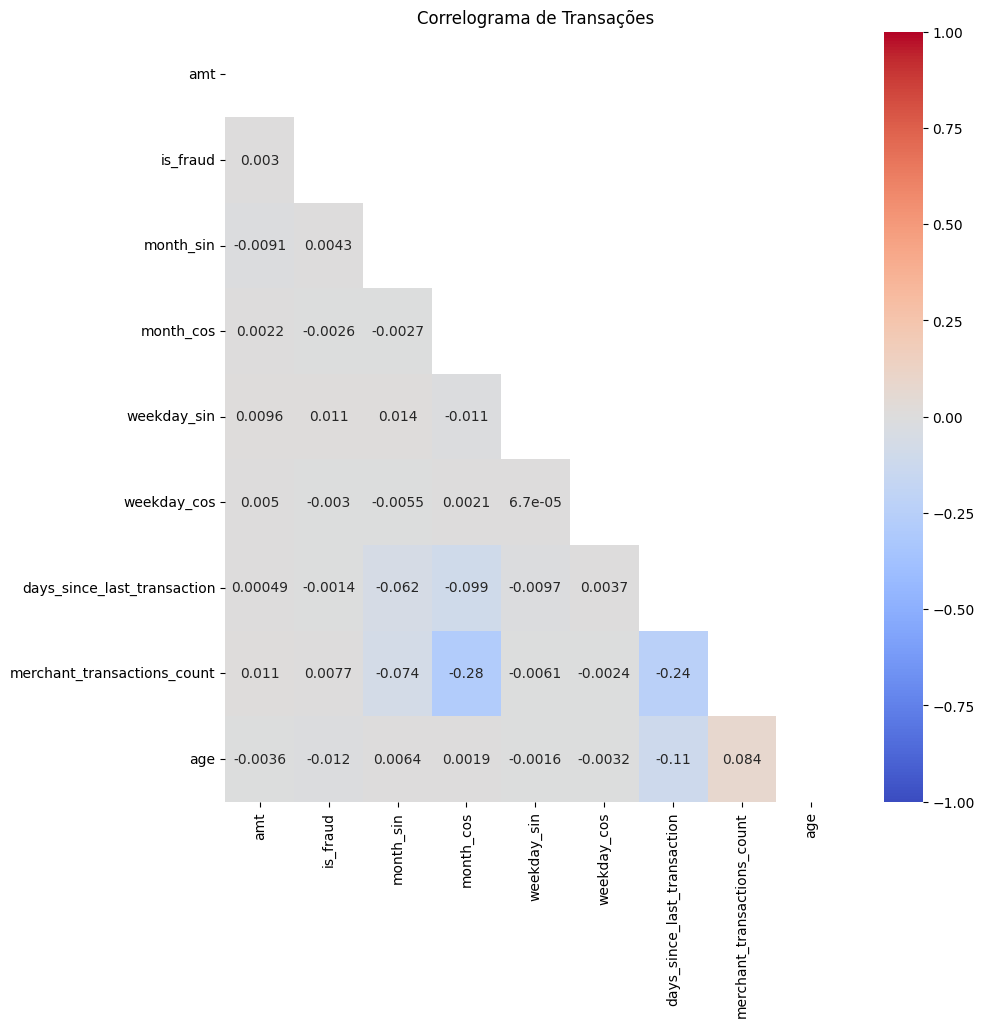

In [91]:
plt.figure(figsize = (10, 10))

correlation = data.select_dtypes(['float', 'int']).corr()
sb.heatmap(correlation, annot = True, cmap = 'coolwarm', mask = np.triu(np.ones_like(correlation, dtype = bool)), vmin = -1, vmax = 1)
contextualize('Correlograma de Transações', '', '')

Efetivamente, não se identifica nenhuma correlação significativa entre as variáveis numéricas e a variável-alvo.

A par desta análise, pode verificar-se também se existe algum padrão relevante na proporção de transações fraudulentas, relativamente aos diferentes valores que as variáveis categóricas podem assumir. Deste modo, elencam-se de seguida as questões que se procuram responder.

In [92]:
def plot_table(category, title, xlabel, ylabel):
    plt.figure(figsize = (5, 5))
    table = pd.crosstab(data[category], transactions['is_fraud'])
    row_sum = table.sum(axis = 1)
    percentages = (table.T / row_sum * 100).T
    annotations = [['{} ({}%)'.format(count, round(percentage)) for percentage, count in zip(row, table_row)] for table_row, row in zip(table.values, percentages.values)]
    sb.heatmap(percentages, annot = annotations, fmt = '', cmap = 'coolwarm')
    contextualize(title, xlabel, ylabel)

**"Há algum padrão na distribuição de transações fraudulentas por profissão?"**

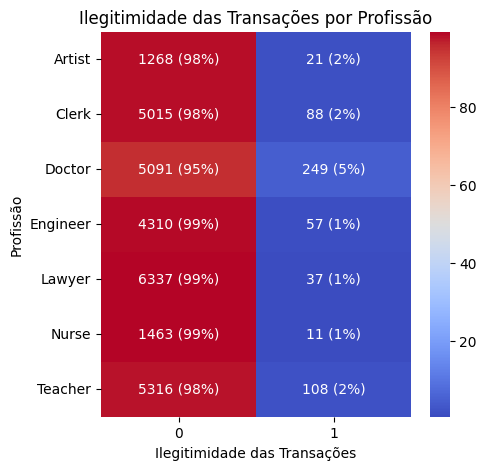

In [93]:
plot_table('job', 'Ilegitimidade das Transações por Profissão', 'Ilegitimidade das Transações', 'Profissão')

Ao observar a tabela, conclui-se que, ainda que a diferença seja reduzida, existe uma maior prevalência de transações fraudulentas nos clientes com a profissão *Doctor*. Todavia, não é garantido que este contraste seja significativo, mas justifica a manutenção do atributo *job* (codificado) nos dados a serem ingeridos pelo modelo.

In [94]:
data = data.drop('job', axis = 1)

**"Há alguma relevância na categoria dos comerciantes para a determinação da legitimidade de uma transação?"**

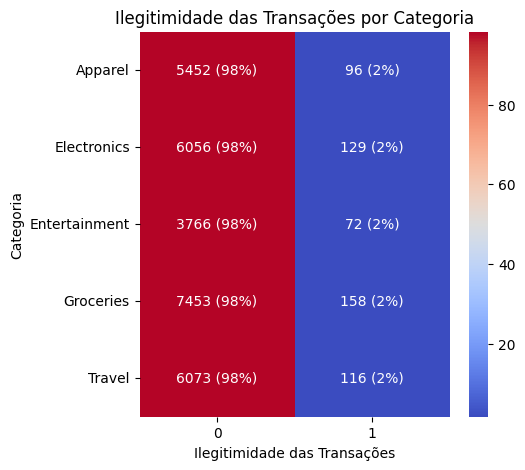

In [95]:
plot_table('category', 'Ilegitimidade das Transações por Categoria', 'Ilegitimidade das Transações', 'Categoria')

Nesta tabela, verifica-se que a proporção de transações fraudulentas é exatamente igual em cada categoria possível dos comerciantes, pelo que este atributo, isoladamente, não será decisivo para a classificação de uma transação. Ainda assim, mantendo-se aberta a possibilidade de esta coluna ser relevante quando considerada juntamente com outras colunas, decide-se mantê-la nos dados para o modelo.

In [96]:
data = data.drop('category', axis = 1)

**"Algum género tem mais tendência para efetuar transações fraudulentas?"**

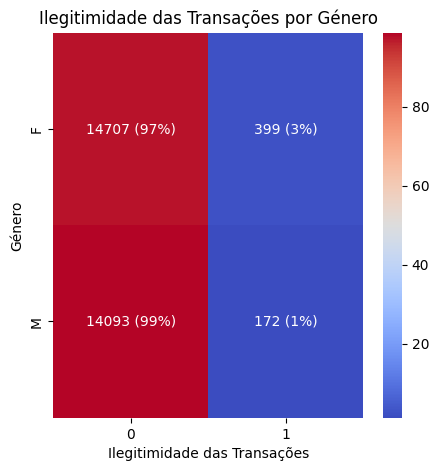

In [97]:
plot_table('gender', 'Ilegitimidade das Transações por Género', 'Ilegitimidade das Transações', 'Género')

Da visualização da tabela, evidencia-se que existe uma maior prevalência de transações fraudulentas nos clientes do género feminino. Tal como anteriormente, os valores são extremamente pequenos, mas, dada a existência de uma diferença, a informação de género será mantida no modelo.

In [98]:
data = data.drop('gender', axis = 1)

**"Há alguma cidade com maior proporção de transações fraudulentas?"**

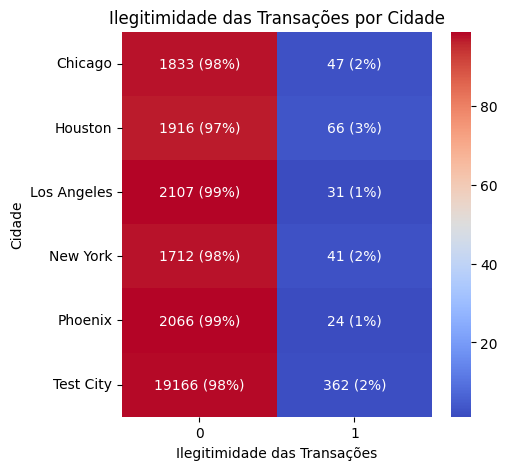

In [99]:
plot_table('city', 'Ilegitimidade das Transações por Cidade', 'Ilegitimidade das Transações', 'Cidade')

A tabela exposta demonstra que não existe nenhum padrão na distribuição de transações fraudulentas/legítimas por cidade, dado que as diferenças entre as cidades devem ser meras flutuações sem explicação aparente. Apesar disso, na expectativa de que o algoritmo encontre alguma importância/relevância nos atributos correspondentes às cidades, estes serão mantidos.

In [100]:
data = data.drop('city', axis = 1)

Finalmente, a análise descritiva deve ser complementada por modelação descritiva, ou seja, pela realização de agrupamento (*clustering*) dos dados.

Nesse sentido, podem ser explorados dois métodos de agrupamento particional: os algoritmos *k-means* e *Density-Based Clustering of Applications with Noise* (DBSCAN). Não se considera relevante/pertinente realizar agrupamento hierárquico, visto que não é expectável que exista alguma hierarquia relevante entre eventuais grupos de valores, dado que o problema a tratar é de classificação binária.

Previamente ao agrupamento dos dados, estes devem ser normalizados através de *Standardization*, de maneira a uniformizar as amplitudes das escalas dos diferentes atributos numéricos e evitar que os atributos de maior magnitude absorvam/dominem os atributos de menor magnitude.

Para além disso, antes de correr o algoritmo *k-means*, deve ainda ser determinado o número ideal de grupos, nomeadamente através do coeficiente de silhueta (*silhouette-based method*) e do método do cotovelo (*elbow method*). Assim, pode testar-se um número de grupos entre 2 (mínimo) e 10 (máximo).

Num primeiro momento, o agrupamento pretenderá responder à questão **"Existem grupos de transações por idade e quantia, isto é, há alguma tendência para uma determinada faixa etária fazer transações de uma dada quantia?"**, pelo que apenas se utilizarão as variáveis *age* e *amt*, já normalizadas.

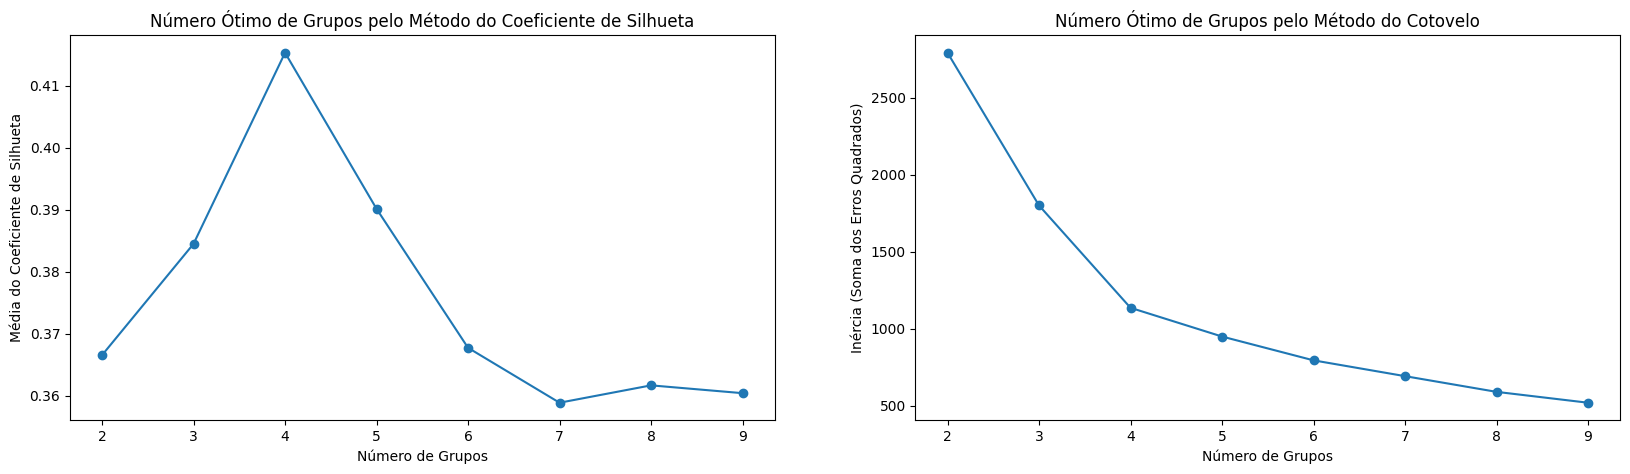

In [101]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['age', 'amt']])

k_range = range(2, 10)

silhouette_coefficients = []
inertias = []
for k in k_range:
    kmeans = KMeans(k, random_state = 10)
    labels = kmeans.fit_predict(scaled_data)
    silhouette_coefficient = silhouette_score(scaled_data, labels)
    silhouette_coefficients.append(silhouette_coefficient)
    inertias.append(kmeans.inertia_)

plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_coefficients, marker = 'o')
contextualize('Número Ótimo de Grupos pelo Método do Coeficiente de Silhueta', 'Número de Grupos', 'Média do Coeficiente de Silhueta')

plt.subplot(1, 2, 2)
plt.plot(k_range, inertias, marker = 'o')
contextualize('Número Ótimo de Grupos pelo Método do Cotovelo', 'Número de Grupos', 'Inércia (Soma dos Erros Quadrados)')

plt.show()

Assim, conclui-se que o número ideal de grupos é 4, por ser o valor de *k* que retorna o coeficiente de silhueta mais elevado e por também ser o valor de *k* a partir do qual adicionar outro grupo não retorna uma inércia (soma dos erros quadrados) muito menor.

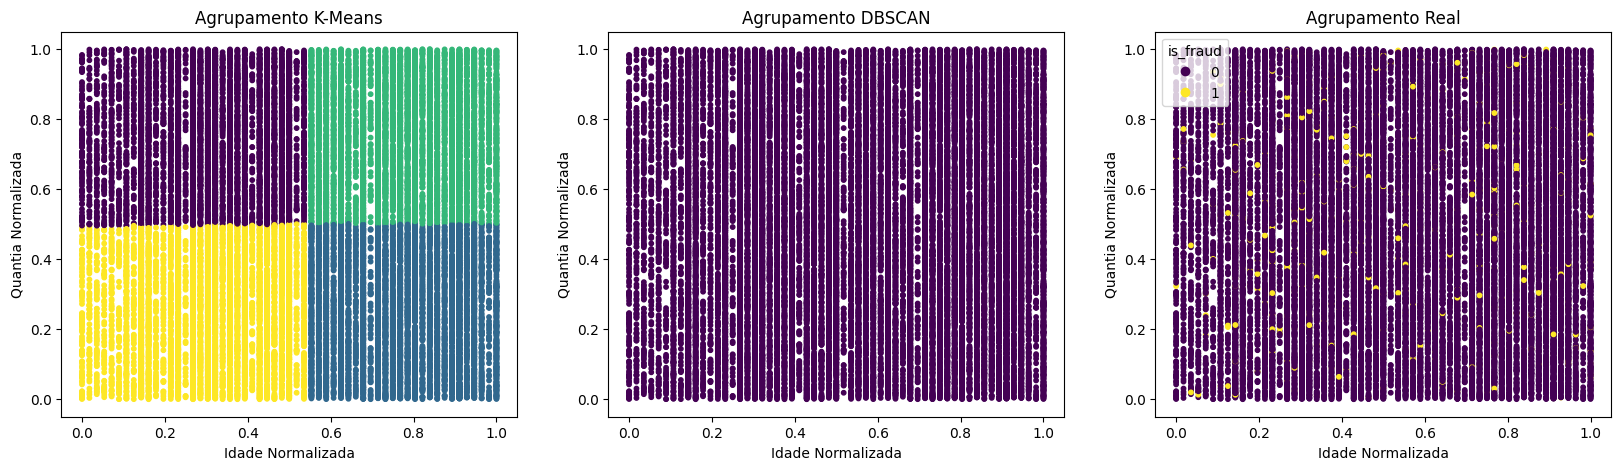

In [102]:
kmeans = KMeans(4, random_state = 10)
kmeans_labels = kmeans.fit_predict(scaled_data)

dbscan = DBSCAN(eps = 0.05)
dbscan_labels = dbscan.fit_predict(scaled_data)

plt.figure(figsize = (20, 5))

plt.subplot(1, 3, 1)
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], s = 10, c = kmeans_labels)
contextualize('Agrupamento K-Means', 'Idade Normalizada', 'Quantia Normalizada')

plt.subplot(1, 3, 2)
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], s = 10, c = dbscan_labels)
contextualize('Agrupamento DBSCAN', 'Idade Normalizada', 'Quantia Normalizada')

plt.subplot(1, 3, 3)
scatterplot = plt.scatter(scaled_data[:, 0], scaled_data[:, 1], s = 10, c = data['is_fraud'])
contextualize('Agrupamento Real', 'Idade Normalizada', 'Quantia Normalizada')
plt.legend(*scatterplot.legend_elements(), title = 'is_fraud')

plt.show()

Efetivamente, através da análise dos grupos formados, quer pelo algoritmo *k-means*, quer pelo método DBSCAN, não se consegue extrair nenhuma informação relevante que responda de forma satisfatória à questão colocada anteriormente. A par disso, também não se encontra nenhuma ligação entre os grupos determinados através dos métodos de agrupamento e a distribuição real de transações fraudulentas e legítimas.

Deste modo, dá-se por concluída a análise descritiva dos dados.

### Formatação dos Dados

Como última etapa da fase de preparação de dados, os dados devem ser formatados para serem adequadamente ingeridos pelo modelo e para traduzirem adequadamente as grandezas que representam.

In [103]:
data.dtypes

merchant                        object
amt                            float64
is_fraud                         int64
month_sin                      float64
month_cos                      float64
weekday_sin                    float64
weekday_cos                    float64
days_since_last_transaction    float64
merchant_transactions_count      int64
age                              int32
dtype: object

Dado que alguns modelos a testar necessitam que todos os atributos sejam numéricos, torna-se necessário codificar os atributos categóricos não ordinais, convertendo-os em atributos numéricos, nomeadamente através de binarização e *one-hot encoding*.

Note-se que a coluna *merchant* contém valores categóricos nominais e cerca 100 valores únicos/distintos, pelo que realizar *one-hot encoding* iria criar cerca de 100 novos atributos para o modelo tratar. Como tal, tendo em conta que o comerciante não foi considerado claramente relevante para a classificação de uma transação como fraudulenta ou legítima, opta-se por remover o atributo *merchant*, de modo a não aumentar drasticamente o número de colunas do modelo.

In [104]:
formatted_data = data.drop('merchant', axis = 1)

formatted_data.dtypes

amt                            float64
is_fraud                         int64
month_sin                      float64
month_cos                      float64
weekday_sin                    float64
weekday_cos                    float64
days_since_last_transaction    float64
merchant_transactions_count      int64
age                              int32
dtype: object

Assim, as colunas em que é necessário realizar *one-hot encoding* são: TODO.

In [105]:
formatted_data = pd.get_dummies(formatted_data, drop_first = True)

formatted_data.dtypes

amt                            float64
is_fraud                         int64
month_sin                      float64
month_cos                      float64
weekday_sin                    float64
weekday_cos                    float64
days_since_last_transaction    float64
merchant_transactions_count      int64
age                              int32
dtype: object

Finalmente, apenas por questões de consistência e simplicidade, pode ainda ser formatada a coluna *age*.

Como este atributo traduz valores inteiros, mas está formatado como valores de vírgula flutuante, pode, sem perda de informação e para maior simplicidade computacional, ser convertido para o tipo inteiro.

In [106]:
formatted_data['age'] = formatted_data['age'].astype(int)

formatted_data.dtypes

amt                            float64
is_fraud                         int64
month_sin                      float64
month_cos                      float64
weekday_sin                    float64
weekday_cos                    float64
days_since_last_transaction    float64
merchant_transactions_count      int64
age                              int32
dtype: object

Antes de considerar os dados como prontos, podem ainda ser ordenadas as colunas alfabeticamente, de maneira a garantir que não existem inconsistências na ordem dos atributos.

In [107]:
formatted_data = formatted_data.sort_index(axis = 1)

formatted_data.head()

,age,amt,days_since_last_transaction,is_fraud,merchant_transactions_count,month_cos,month_sin,weekday_cos,weekday_sin
0,31,354.15,0.000,0,0,1.000,0.0,-0.223,-0.975
1,31,16.02,115.461,0,0,0.866,-0.5,-0.901,0.434
2,31,478.15,2.840,0,0,1.000,0.0,0.623,0.782
3,31,275.31,69.612,0,0,-0.866,-0.5,-0.901,0.434
4,31,177.68,134.899,0,0,-0.866,0.5,-0.901,0.434


Assim sendo, os dados estão, finalmente, prontos para serem ingeridos pelo modelo.

In [108]:
formatted_data.to_csv('data/data.csv', index = False)

new_customers.to_csv('kaggle/customers.csv', index = False)
new_merchants.to_csv('kaggle/merchants.csv', index = False)